* ADHANA  Melaku Hayelom
* BASTOS BONN TOSCANO Beatriz
* BELO BARBOSA Raphaella  



# Assignment 1: Model

## Description of the building

The first step is to design a two zone building, which is composed of two rooms, with one window each, one door to the outside and one connecting both rooms. On boundary conditions, we take into account that walls 1,2 and 3 have solar irradiation. Moreover,  walls 4, 5 and 6 are adiabatic, as if they are one that has no heat transfer. Doors 1 and 2 are closed. Along with that, the apartment is isolated so there is no heat transfer through the floor or ceiling. It's thermal circuit can be seen on the report.

# Information on the materials and controllers

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


In [2]:
#Concrete
lambda_concrete = 1.4 #W/mK # lambda = thermal conductivity
density_concrete = 2300 #kg/m^3
spec_heat_cap_concrete = 880 #J/kgK
width_concrete = 0.02/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Insulation
lambda_insulation = 0.04 #W/mK
density_insulation = 16 #kg/m^3
spec_heat_cap_insulation = 1210 #J/kgK
width_insulation = 0.08/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Window
uvalue_window = 1.4 #W/m2K
density_window = 2500 #kg/m^3
spec_heat_cap_window = 1210#J/kgK
width_window = 0.04 #m
surface_window = 1

#Door
uvalue_door = 0.9 #W/m2K
density_door = 314 #kg/m^3
spec_heat_cap_door = 2380 #J/kgK
width_door = 0.044 #m
surface_door = 2

#Walls
h_out = 10 #W/m^2*K convection coefficient between outdoor air and wall
h_in = 4 #W/m^2*K convection coefficient between indoor air and wall
l = 3 #length of walls 1,4,7
L = 4 #length of walls 2,3,5,6
surface_wall1 = surface_wall7 = L*3 #surface of walls 1,4,7
surface_wall2 = surface_wall3 = l*3 #surface of walls 2,3,5,6

#Air
density_air= 1.2
spec_heat_cap_air=1000
volume_air= 3*l*L

#P-controller gain: if Kp = 0, the controller is off
Kp1 =10**5
Kp2= 10**5

#Setpoint temeratures for the Room 1 and Room 2
Tsp1 = 25
Tsp2 = 25
Tout = -5

# Mathematical model

After the thermal circuit was done, we passed to the calculation of thermal conductances and thermal capacities. To model our building, these equations will be used on the three matrices of the Algebraic Differential Equations (DAE): incidence A, conductance G and capacity C. Along with that two vectors: temperature sources b and flow-rate sources f.


## Matrix A

Matrix A correlates the flow rates and nodes. Each line is a flow and each column is a node. A[i,j] is then the relation between flow i and node j, that can be:


* 0, if the flow is not connected to node
* +1, if flow enters into node
* -1, if flow gets out of node

In [3]:
#Matrix A
#lines are heat transfer flows/resistances and columns are nodes
#the last two lines are the controllers

A = np.zeros([28,21])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 6],A[6, 7] = 1, -1
A[7, 7],A[7, 8] = 1, -1
A[8, 8], A[8, 9] = 1, -1
A[9, 9], A[9, 10] = 1, -1
A[10, 10], A[10, 11] = 1, -1
A[11, 11]= 1
A[12, 6]= 1
A[13, 5] = 1
A[14, 5], A[14, 12] = 1, -1
A[15, 12], A[15, 13] = 1, -1
A[16, 13], A[16, 14] = 1, -1
A[17, 14], A[17, 15] = 1, -1
A[18, 5], A[18, 15] = 1, -1
A[19, 15] = 1
A[20, 15], A[20, 16] = 1, -1
A[21, 16], A[21, 17] = 1, -1
A[22, 17], A[22, 18] = 1, -1
A[23, 18], A[23, 19] = 1, -1
A[24, 19], A[24, 20] = 1, -1
A[25, 20]= 1
A[26, 5]= 1 #Controller 1
A[27, 15]= 1 #Controller 2

#print('This is the incidence matrix A:')
print(A)

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0.  0.  0.

## Matrix G

Matrix G is the diagonal matrix that contains the conductances of each flow starting from node 0 that can be for the wall outdoor convection, conduction and indoor convection. As well as conductance for doors and windows. All the equations are explained on the report.


In [4]:
#Matrix G
#Diagonal matrix containing the conductances (inverse of the conduction and convection resistances)
# conduction conductance = (lambda*surface)/width
# convection conductance = (conv.coef.)*surface

g =[h_out*surface_wall2, #convection out of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     h_in*surface_wall2, #convection in of wall 2
     h_in*surface_wall1, #convection in of wall 1
     lambda_concrete*surface_wall1/width_concrete,#conduction concrete of wall 1
     lambda_concrete*surface_wall1/width_concrete, #conduction concrete of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     h_out*surface_wall1, #convection out of wall 1
     uvalue_door, #conductance door1 of wall 1
     uvalue_window, #conductance window1 of wall 2
     h_in*surface_wall7, #convection in of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     h_in*surface_wall7, #convection in of wall 7
     uvalue_door, #conductance door2 of of wall 7
     uvalue_window, #conductance window2 of wall 3
     h_in*surface_wall3, #convection in of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     h_out*surface_wall3,#convection out of wall 3
     Kp1, #controller Room 1 with walls 1,2,6,7
     Kp2] #controller Room 2 with walls 3,4,5,7

G = np.diag(g)

rows, columns = G.shape

#print('This is the conductance matrix G:')
#print("The matrix G has", rows, "rows and",columns,"columns")


## Thermal capacities and Matrix C

Matrix C is the diagonal matrix containing the thermal capacities of each node starting from node 0.The thermal capacities of the materials air, concrete and insulation were calculated. It is important to note that for steady-state the capacitances are considered zero.

In [5]:
#Thermal Capacities

#Wall 1 = wall 7 but without insulation
C_concrete1 = C_concrete7 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall1)
C_insulation1 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall1)

#Wall 2 = wall 3
C_concrete2 = C_concrete3 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall2)
C_insulation2 = C_insulation3 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall2)

#Air
C_air=density_air*spec_heat_cap_air*volume_air #thermal capacity


In [6]:
# Matrix C
#Diagonal matrix containing the capacities

C=np.zeros([21,21])

C[1,1]=C_insulation2     #Wall 2
C[3,3]=C_concrete2       #Wall 2
C[5,5]=C_air             #Air
C[8,8]=C_concrete1       #Wall 1
C[10,10]=C_insulation1   #Wall 1
C[13,13]=C_concrete7     #Wall 7
C[15,15]=C_air           #Air
C[17,17]=C_concrete3     #Wall 3
C[19,19]=C_insulation3   #Wall 3

#print('This is the capacity matrix C:')
#print(C)

## Vectors b and f

Vector b [28,1] sets the temperature sources for each heat flow rate following the sign convention that is positif from low to high temperatures. And the vector f [21,1] sets the flow rate sources for each node.
For testing the model we considered a hypothetical outside temperature of -5 $^oC$ and the setpoint temperature for the controllers of 25 $^oC$ (Tsp).

In [7]:
#Vectors

#b: temperature sources, associated to heat flow rate (q)
b = np.zeros(28)
b[[0,11,12,13,19,25]] = Tout #Outside temperature
b[26],b[27]= Tsp1, Tsp2 #Controller setpoints

#f: flow-rate sources, associated to the nodes (theta)
f = np.zeros(21)

#y: output vector
y = np.zeros(21)  # nodes
y[[5,15]]  = 1    # nodes (temperatures) of interest

# Assignment 2: Steady-state

## Differential-Algebraic Equations (DAE) and steady-state solution

After testing and validating the model in steady-sate (without the controllers), we tried it with perfect controlers (very high Kp). The implementation and results can be seen below

In [8]:
#State-space model

# Temperature vector in steady-state
theta =(np.linalg.inv(np.transpose(A) @ G @ A)) @ (np.transpose(A) @ G @ b + f)
# Flow-rate vector in steady-state
q = G @ (-A @ theta + b)
normal_q = q
#Controller error
error1 = Tsp1 - theta[5]
error2 = Tsp2 - theta[15]

#Heat flow rate by the controller
q1 = Kp1*error1
q2 = Kp2*error2

print("The temperatures on the nodes are:")
print(theta)
print()
print("The heat flow on each resistance is:")
print(q)
print()
print("The error of controller 1 is:", error1, "and for controller 2 is:", error2)
print("The heat flow rate of controller 1 is:", q1, "and for controller 2 is:", q2)


The temperatures on the nodes are:
[-3.73118389  8.95697724 21.64513836 21.73576808 21.82639781 24.99843809
 -5.         -5.         -5.         -5.         -5.         -5.
 24.99843809 24.99843809 24.99843809 24.99843809 21.82639781 21.73576808
 21.64513836  8.95697724 -3.73118389]

The heat flow on each resistance is:
[-1.14193450e+02 -1.14193450e+02 -1.14193450e+02 -1.14193450e+02
 -1.14193450e+02 -1.14193450e+02  8.52651283e-14  0.00000000e+00
  1.49213975e-12 -4.58300065e-13 -4.47641924e-13 -4.26325641e-13
 -6.87450097e-14 -4.19978133e+01 -3.24007488e-12  0.00000000e+00
  5.96855898e-12  2.89901436e-12 -3.19744231e-15 -4.19978133e+01
 -1.14193450e+02 -1.14193450e+02 -1.14193450e+02 -1.14193450e+02
 -1.14193450e+02 -1.14193450e+02  1.56191263e+02  1.56191263e+02]

The error of controller 1 is: 0.0015619126344326162 and for controller 2 is: 0.001561912634436169
The heat flow rate of controller 1 is: 156.19126344326162 and for controller 2 is: 156.1912634436169


# State-space representation

[-5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -5. -5. -5.  0.  0.  0.  0.
  0. -5.  0.  0.  0.  0.  0. -5. 25. 25.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
The heat flow on each resistance is:
[-3.68790744e+01 -4.54888507e+01 -6.18621185e+00  1.57389790e+03
 -1.15817210e+02  3.75730408e-02  2.97506349e+02 -1.86517468e-12
 -7.62427605e+02 -8.24828247e+00 -6.06518009e+01 -4.91720992e+01
 -3.66496318e-01 -6.99046671e+00 -2.33159082e+01  1.61863794e+03
  4.11580744e+04 -1.19869972e+03  3.30294256e-03 -6.99560462e+00
 -1.86285960e+01  1.83747105e+03  3.02803973e+04 -2.20489684e+02
 -8.67127469e+00 -4.05669818e+02  2.50068095e+06  2.50031396e+06]


Difference between ststae-space solution and normal DAE q:
[ 7.73143758e+01  6.87045995e+01  1.08007238e+02  1.68809135e+03
 -1.62376029e+00  1.14231023e+02  2.97506349e+02 -1.86517468e-12
 -7.62427605e+02 -8.24828247e+00 -6.06518009e+01 -4.91720992e+01
 -3.66496318e-01  3.50073466e+01 -2.33159082e+01  1

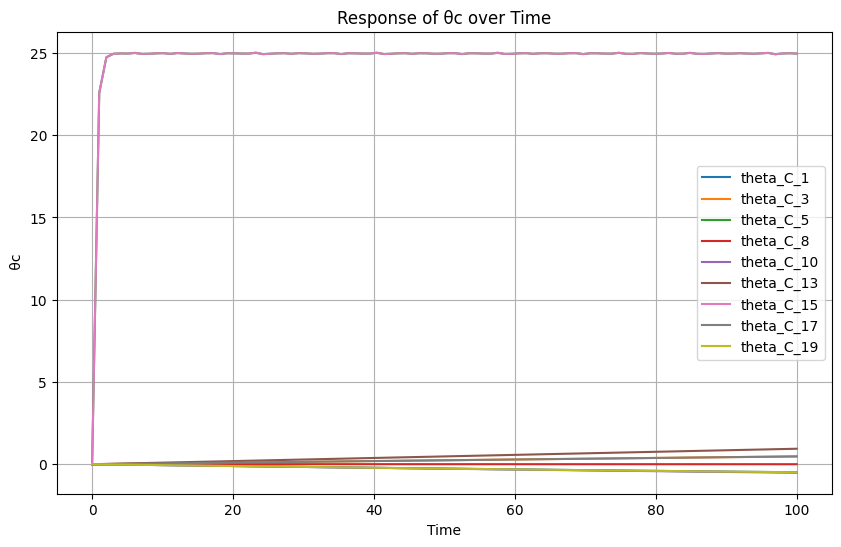

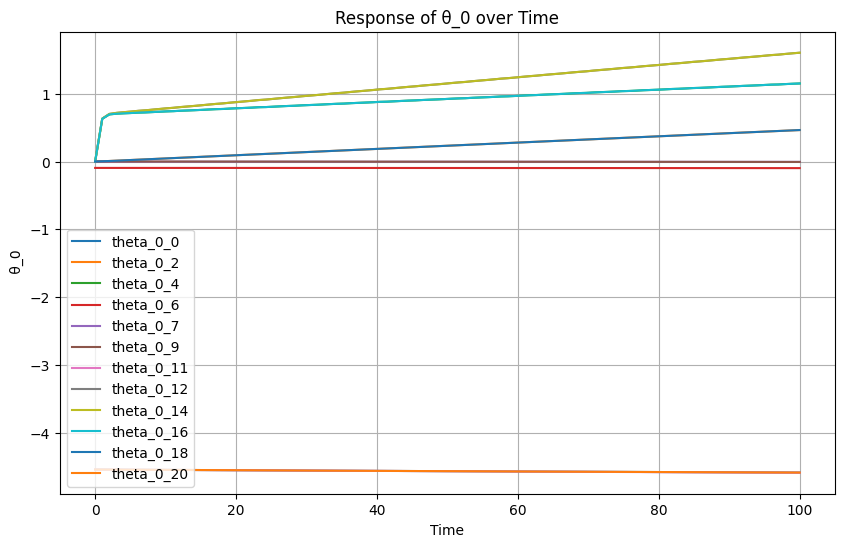

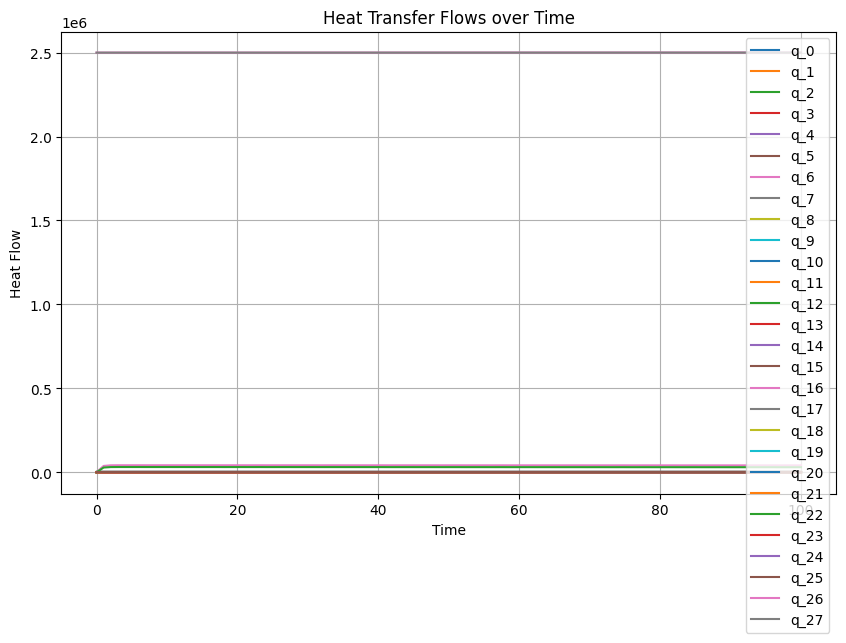

In [9]:
#State matrix
no_θ = 21
no_q = 28

#Concrete
lambda_concrete = 1.4 #W/mK # lambda = thermal conductivity
density_concrete = 2300 #kg/m^3
spec_heat_cap_concrete = 880 #J/kgK
width_concrete = 0.02/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Insulation
lambda_insulation = 0.04 #W/mK
density_insulation = 16 #kg/m^3
spec_heat_cap_insulation = 1210 #J/kgK
width_insulation = 0.08/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Window
uvalue_window = 1.4 #W/m2K
density_window = 2500 #kg/m^3
spec_heat_cap_window = 1210#J/kgK
width_window = 0.04 #m
surface_window = 1

#Door
uvalue_door = 0.9 #W/m2K
density_door = 314 #kg/m^3
spec_heat_cap_door = 2380 #J/kgK
width_door = 0.044 #m
surface_door = 2

#Walls
h_out = 10 #W/m^2*K convection coefficient between outdoor air and wall
h_in = 4 #W/m^2*K convection coefficient between indoor air and wall
l = 3 #length of walls 1,4,7
L = 4 #length of walls 2,3,5,6
surface_wall1 = surface_wall7 = L*3 #surface of walls 1,4,7
surface_wall2 = surface_wall3 = l*3 #surface of walls 2,3,5,6

#Air
density_air= 1.2
spec_heat_cap_air=1000
volume_air= 3*l*L

#P-controller gain: if Kp = 0, the controller is off
Kp1 =10**5
Kp2= 10**5

#Setpoint temeratures for the Room 1 and Room 2
Tsp1 = 25
Tsp2 = 25
Tout = -5
E = 0            #solar irradiance for summer, for winter it's 0
occupation = 0     #number of people inside
heatppl = 0.1 * occupation
alfa = 0.95        # short wave absortivity grey painted wall
thermal_transmittance = 0.2
total_surface = (surface_wall1*2 + surface_wall2*2)
cteforf = alfa*thermal_transmittance*E/total_surface

#Matrix A
A = np.zeros([28,21])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 6],A[6, 7] = 1, -1
A[7, 7],A[7, 8] = 1, -1
A[8, 8], A[8, 9] = 1, -1
A[9, 9], A[9, 10] = 1, -1
A[10, 10], A[10, 11] = 1, -1
A[11, 11]= 1
A[12, 6]= 1
A[13, 5] = 1
A[14, 5], A[14, 12] = 1, -1
A[15, 12], A[15, 13] = 1, -1
A[16, 13], A[16, 14] = 1, -1
A[17, 14], A[17, 15] = 1, -1
A[18, 5], A[18, 15] = 1, -1
A[19, 15] = 1
A[20, 15], A[20, 16] = 1, -1
A[21, 16], A[21, 17] = 1, -1
A[22, 17], A[22, 18] = 1, -1
A[23, 18], A[23, 19] = 1, -1
A[24, 19], A[24, 20] = 1, -1
A[25, 20]= 1
A[26, 5]= 1 #Controller 1
A[27, 15]= 1 #Controller 2

#Matrix G
g =[h_out*surface_wall2, #convection out of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     h_in*surface_wall2, #convection in of wall 2
     h_in*surface_wall1, #convection in of wall 1
     lambda_concrete*surface_wall1/width_concrete,#conduction concrete of wall 1
     lambda_concrete*surface_wall1/width_concrete, #conduction concrete of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     h_out*surface_wall1, #convection out of wall 1
     uvalue_door, #conductance door1 of wall 1
     uvalue_window, #conductance window1 of wall 2
     h_in*surface_wall7, #convection in of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     h_in*surface_wall7, #convection in of wall 7
     uvalue_door, #conductance door2 of of wall 7
     uvalue_window, #conductance window2 of wall 3
     h_in*surface_wall3, #convection in of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     h_out*surface_wall3,#convection out of wall 3
     Kp1, #controller Room 1 with walls 1,2,6,7
     Kp2] #controller Room 2 with walls 3,4,5,7
G = np.diag(g)

#Thermal Capacities
C_concrete1 = C_concrete7 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall1)
C_insulation1 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall1)
C_concrete2 = C_concrete3 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall2)
C_insulation2 = C_insulation3 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall2)
C_air=density_air*spec_heat_cap_air*volume_air #thermal capacity

# Matrix C
C=np.zeros([21,21])
C[1,1]=C_insulation2     #Wall 2
C[3,3]=C_concrete2       #Wall 2
C[5,5]=C_air             #Air
C[8,8]=C_concrete1       #Wall 1
C[10,10]=C_insulation1   #Wall 1
C[13,13]=C_concrete7     #Wall 7
C[15,15]=C_air           #Air
C[17,17]=C_concrete3     #Wall 3
C[19,19]=C_insulation3   #Wall 3

#b: temperature sources, associated to heat flow rate (q)
b = np.zeros(28)
b[[0,11,12,13,19,25]] = Tout #Outside temperature
b[26],b[27]= Tsp1, Tsp2 #Controller setpoints

#f: flow-rate sources, associated to the nodes (theta)
f = np.zeros(21)
f[0] = E*alfa*surface_wall2    #Wall 2
f[4] = surface_wall2*cteforf   #Wall 2
f[7] = surface_wall1*cteforf   #Wall 1
f[11] = E*alfa*surface_wall1   #Wall 1
f[12] = surface_wall7*cteforf  #Wall 7
f[14] = surface_wall7*cteforf  #Wall 7
f[16] = surface_wall3*cteforf  #Wall 3
f[20] = E*alfa*surface_wall3   #Wall 3

#y: output vector
y = np.zeros(21)  # nodes
y[[5,15]]  = 1    # nodes (temperatures) of interest

#Step-response
idx_C = np.where(np.diag(C) != 0)[0] #Indices nodes with capacities
idx_0 = np.where(np.diag(C) == 0)[0] #Indices nodes without capacities
Cc = C[np.ix_(idx_C, idx_C)] #Eliminate nodes without capacities
K = - np.transpose(A) @ G @ A
K11 = K[np.ix_(idx_0, idx_0)]
K12 = K[np.ix_(idx_0, idx_C)]
K21 = K[np.ix_(idx_C, idx_0)]
K22 = K[np.ix_(idx_C, idx_C)]
Kb = np.transpose(A) @ G
Kb1 = Kb[idx_0, :] #Extract the rows of Kb of nodes without capacities
Kb2 = Kb[idx_C, :] #Extract the rows of Kb of nodes with capacities
fc = f[idx_C] #flow sources at nodes with capacities
f0 = f[idx_0] #flow sources at nodes without capacities
u = np.concatenate([b, f0, fc])
print(u)

#As state matrix
As = np.linalg.inv(Cc) @ (-K21 @ np.linalg.inv(K11) @ K12 + K22)
#Bs input matrix
Bs = np.linalg.inv(Cc) @ np.hstack([-K21 @ np.linalg.inv(K11) @ Kb1 + Kb2, -K21 @ np.linalg.inv(K11), np.eye(len(idx_C))])
#Cs output matrix
Cs = -np.linalg.inv(K11) @ K12
#feedthrough
#Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0))])
Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0)), np.zeros((len(idx_0), len(idx_C)))])

#Solve the state-space equation
#Inputs
t_start = 0
t_end = 100
t_eval = np.linspace(t_start, t_end, 100) #Evaluate at time points
θc_initial = np.zeros(len(idx_C))
#Define the system
def state_space_system(t, θc, As, Bs, u):
    d_θc_dt = As @ θc + Bs @ u
    return d_θc_dt
#Solve the state equation
sol = solve_ivp(state_space_system, (t_start, t_end), θc_initial, args=(As, Bs, u), t_eval=t_eval, dense_output=True)
#Extract θc, θ0, q
theta_C_t = sol.y.T #Extract solution for θc
theta_0_t = Cs @ sol.y + Ds @ u.reshape(-1, 1) #Extract the soluction for θ0
theta_t = np.vstack([theta_0_t, theta_C_t.T]) #Complete temperature vector
q_t = G @ (-A @ theta_t + b.reshape(-1, 1)) #Heat transfer flows q
#Check the different between the two methods
difference = q_t[:, -1] - normal_q
print("The heat flow on each resistance is:") # Print the last time step's flow values
print(q_t[:, -1])
print()
print("\nDifference between ststae-space solution and normal DAE q:")
print(difference)

#Plot
plt.figure(figsize=(10, 6))
for i in range(theta_C_t.shape[1]):
    plt.plot(t_eval, theta_C_t[:, i], label=f'theta_C_{idx_C[i]}')
plt.xlabel('Time')
plt.ylabel(' θc')
plt.title('Response of θc over Time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for i in range(theta_0_t.shape[0]):
    plt.plot(t_eval, theta_0_t[i, :], label=f'theta_0_{idx_0[i]}')
plt.xlabel('Time')
plt.ylabel(' θ_0')
plt.title('Response of θ_0 over Time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for i in range(q_t.shape[0]):
    plt.plot(t_eval, q_t[i, :], label=f'q_{i}')
plt.xlabel('Time')
plt.ylabel('Heat Flow')
plt.title('Heat Transfer Flows over Time')
plt.legend()
plt.grid(True)
plt.show()

# Case1: summer unoccupied

In [10]:

#PREVIOUS CODE
#Concrete
lambda_concrete = 1.4 #W/mK # lambda = thermal conductivity
density_concrete = 2300 #kg/m^3
spec_heat_cap_concrete = 880 #J/kgK
width_concrete = 0.02/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Insulation
lambda_insulation = 0.04 #W/mK
density_insulation = 16 #kg/m^3
spec_heat_cap_insulation = 1210 #J/kgK
width_insulation = 0.08/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Window
uvalue_window = 1.4 #W/m2K
density_window = 2500 #kg/m^3
spec_heat_cap_window = 1210#J/kgK
width_window = 0.04 #m
surface_window = 1
#Door
uvalue_door = 0.9 #W/m2K
density_door = 314 #kg/m^3
spec_heat_cap_door = 2380 #J/kgK
width_door = 0.044 #m
surface_door = 2
#Walls
h_out = 10 #W/m^2*K convection coefficient between outdoor air and wall
h_in = 4 #W/m^2*K convection coefficient between indoor air and wall
l = 3 #length of walls 1,4,7
L = 4 #length of walls 2,3,5,6
surface_wall1 = surface_wall7 = L*3 #surface of walls 1,4,7
surface_wall2 = surface_wall3 = l*3 #surface of walls 2,3,5,6
#Air
density_air= 1.2
spec_heat_cap_air=1000
volume_air= 3*l*L
#P-controller gain: if Kp = 0, the controller is off
Kp1 =10**5
Kp2= 10**5
#NEW INFORMATION
Tsp1 = 20          #if occupied: 22, if not: 20
Tsp2 = 20
Tout= 24           #summer
E = 100            #solar irradiance for summer, for winter it's 0
occupation = 0     #number of people inside
heatppl = 0.1 * occupation
alfa = 0.95        #absorptance for grey painted wall
thermal_transmittance = 0.2
total_surface = (surface_wall1*2 + surface_wall2*2)
cteforf = alfa*thermal_transmittance*E/total_surface
#Matrix A
A = np.zeros([28,21])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 6],A[6, 7] = 1, -1
A[7, 7],A[7, 8] = 1, -1
A[8, 8], A[8, 9] = 1, -1
A[9, 9], A[9, 10] = 1, -1
A[10, 10], A[10, 11] = 1, -1
A[11, 11]= 1
A[12, 6]= 1
A[13, 5] = 1
A[14, 5], A[14, 12] = 1, -1
A[15, 12], A[15, 13] = 1, -1
A[16, 13], A[16, 14] = 1, -1
A[17, 14], A[17, 15] = 1, -1
A[18, 5], A[18, 15] = 1, -1
A[19, 15] = 1
A[20, 15], A[20, 16] = 1, -1
A[21, 16], A[21, 17] = 1, -1
A[22, 17], A[22, 18] = 1, -1
A[23, 18], A[23, 19] = 1, -1
A[24, 19], A[24, 20] = 1, -1
A[25, 20]= 1
A[26, 5]= 1 #Controller 1
A[27, 15]= 1 #Controller 2

#Matrix G
g =[h_out*surface_wall2, #convection out of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     h_in*surface_wall2, #convection in of wall 2
     h_in*surface_wall1, #convection in of wall 1
     lambda_concrete*surface_wall1/width_concrete,#conduction concrete of wall 1
     lambda_concrete*surface_wall1/width_concrete, #conduction concrete of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     h_out*surface_wall1, #convection out of wall 1
     uvalue_door, #conductance door1 of wall 1
     uvalue_window, #conductance window1 of wall 2
     h_in*surface_wall7, #convection in of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     h_in*surface_wall7, #convection in of wall 7
     uvalue_door, #conductance door2 of of wall 7
     uvalue_window, #conductance window2 of wall 3
     h_in*surface_wall3, #convection in of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     h_out*surface_wall3,#convection out of wall 3
     Kp1, #controller Room 1 with walls 1,2,6,7
     Kp2] #controller Room 2 with walls 3,4,5,7
G = np.diag(g)

#Matrix C
C_concrete1 = C_concrete7 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall1)
C_insulation1 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall1)
C_concrete2 = C_concrete3 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall2)
C_insulation2 = C_insulation3 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall2)
C_air=density_air*spec_heat_cap_air*volume_air #thermal capacity
C=np.zeros([21,21])
C[1,1]=C_insulation2     #Wall 2
C[3,3]=C_concrete2       #Wall 2
C[5,5]=C_air             #Air
C[8,8]=C_concrete1       #Wall 1
C[10,10]=C_insulation1   #Wall 1
C[13,13]=C_concrete7     #Wall 7
C[15,15]=C_air           #Air
C[17,17]=C_concrete3     #Wall 3
C[19,19]=C_insulation3   #Wall 3

#b vector
b = np.zeros(28)
b[[0,11,12,13,19,25]] = Tout #Outside temperature
b[26],b[27]= Tsp1, Tsp2 #Controller setpoints
bT = np.array([Tout,Tout,Tout,Tout,Tout,Tout,Tsp1, Tsp2])

#NEW INFORMATION
#f vector
f = np.zeros(21)
f[0] = E*alfa*surface_wall2    #Wall 2
f[4] = surface_wall2*cteforf   #Wall 2
f[7] = surface_wall1*cteforf   #Wall 1
f[11] = E*alfa*surface_wall1   #Wall 1
f[12] = surface_wall7*cteforf  #Wall 7
f[14] = surface_wall7*cteforf  #Wall 7
f[16] = surface_wall3*cteforf  #Wall 3
f[20] = E*alfa*surface_wall3   #Wall 3

#PREVIOUS CODE
#y
y = np.zeros(21)  # nodes
y[[5,15]]  = 1    # nodes (temperatures) of interest

#State-space model
theta = (np.linalg.inv(np.transpose(A) @ G @ A)) @ (np.transpose(A) @ G @ b + f)
q = G @ (-A @ theta + b)

#Controller error
error1 = Tsp1 - theta[5]
error2 = Tsp2 - theta[15]

#Heat flow rate by the controller
q1 = Kp1*error1
q2 = Kp2*error2

print("Case 1: summer unnocupied")
print()
print("The temperatures on the nodes are:")
print(theta)
print()
print("The heat flow on each resistance is:")
print(q)
print()
print("The error of controller 1 is:", error1, "and for controller 2 is:", error2)
print("The heat flow rate of controller 1 is:", q1, "and for controller 2 is:", q2)

Case 1: summer unnocupied

The temperatures on the nodes are:
[32.93381444 27.27195889 21.61010334 21.56966151 21.52921968 20.00066056
 32.88156992 33.04809936 33.04962605 33.05115274 33.26488953 33.47862632
 20.1137558  20.1137558  20.1137558  20.00066056 21.52921968 21.56966151
 21.61010334 27.27195889 32.93381444]

The heat flow on each resistance is:
[-8.04043300e+02  5.09567000e+01  5.09567000e+01  5.09567000e+01
  5.09567000e+01  5.50281286e+01  7.99341293e+00  2.56484150e+00
  2.56484150e+00  2.56484150e+00  2.56484150e+00 -1.13743516e+03
 -7.99341293e+00  5.59907522e+00  5.42857143e+00 -1.19371180e-11
  1.19371180e-11 -5.42857143e+00 -3.19744231e-15  5.59907522e+00
  5.50281286e+01  5.09567000e+01  5.09567000e+01  5.09567000e+01
  5.09567000e+01 -8.04043300e+02 -6.60557752e+01 -6.60557752e+01]

The error of controller 1 is: -0.0006605577521092698 and for controller 2 is: -0.0006605577521057171
The heat flow rate of controller 1 is: -66.05577521092698 and for controller 2 is: -6

# Case 2: summer with occupation

In [11]:
#NEW INFORMATION
Tsp1 = 22          #if occupied summer/winter: 22, if not: 20 during summer and 16 during winter
Tsp2 = 22
Tout= 24           #summer
E = 100            #solar irradiance for summer = 100, for winter = 0
occupation = 2     #number of people inside
heatppl = 0.1 * occupation
alfa = 0.95        #absorptance for grey painted wall
thermal_transmittance = 0.2

#Concrete
lambda_concrete = 1.4 #W/mK # lambda = thermal conductivity
density_concrete = 2300 #kg/m^3
spec_heat_cap_concrete = 880 #J/kgK
width_concrete = 0.02/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall
#Insulation
lambda_insulation = 0.04 #W/mK
density_insulation = 16 #kg/m^3
spec_heat_cap_insulation = 1210 #J/kgK
width_insulation = 0.08/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall
#Window
uvalue_window = 1.4 #W/K
density_window = 2500 #kg/m^3
spec_heat_cap_window = 1210#J/kgK
width_window = 0.04 #m
surface_window = 1
#Door
uvalue_door = 0.9 #W/m2K
density_door = 314 #kg/m^3
spec_heat_cap_door = 2380 #J/kgK
width_door = 0.044 #m
surface_door = 2
#Walls
h_out = 10 #W/m^2*K convection coefficient between outdoor air and wall
h_in = 4 #W/m^2*K convection coefficient between indoor air and wall
l = 3 #length of walls 1,4,7
L = 4 #length of walls 2,3,5,6
surface_wall1 = surface_wall7 = L*3 #surface of walls 1,4,7
surface_wall2 = surface_wall3 = l*3 #surface of walls 2,3,5,6
#Air
density_air= 1.2
spec_heat_cap_air=1000
volume_air= 3*l*L
#P-controller gain: if Kp = 0, the controller is off
Kp1 =10**5
Kp2= 10**5

total_surface = (surface_wall1*2 + surface_wall2*2)
cteforf = alfa*thermal_transmittance*E/total_surface

#Matrix A
A = np.zeros([28,21])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 6],A[6, 7] = 1, -1
A[7, 7],A[7, 8] = 1, -1
A[8, 8], A[8, 9] = 1, -1
A[9, 9], A[9, 10] = 1, -1
A[10, 10], A[10, 11] = 1, -1
A[11, 11]= 1
A[12, 6]= 1
A[13, 5] = 1
A[14, 5], A[14, 12] = 1, -1
A[15, 12], A[15, 13] = 1, -1
A[16, 13], A[16, 14] = 1, -1
A[17, 14], A[17, 15] = 1, -1
A[18, 5], A[18, 15] = 1, -1
A[19, 15] = 1
A[20, 15], A[20, 16] = 1, -1
A[21, 16], A[21, 17] = 1, -1
A[22, 17], A[22, 18] = 1, -1
A[23, 18], A[23, 19] = 1, -1
A[24, 19], A[24, 20] = 1, -1
A[25, 20]= 1
A[26, 5]= 1 #Controller 1
A[27, 15]= 1 #Controller 2

#Matrix G
g =[h_out*surface_wall2, #convection out of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     h_in*surface_wall2, #convection in of wall 2
     h_in*surface_wall1, #convection in of wall 1
     lambda_concrete*surface_wall1/width_concrete,#conduction concrete of wall 1
     lambda_concrete*surface_wall1/width_concrete, #conduction concrete of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     h_out*surface_wall1, #convection out of wall 1
     uvalue_door, #conductance door1 of wall 1
     uvalue_window, #conductance window1 of wall 2
     h_in*surface_wall7, #convection in of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     h_in*surface_wall7, #convection in of wall 7
     uvalue_door, #conductance door2 of of wall 7
     uvalue_window, #conductance window2 of wall 3
     h_in*surface_wall3, #convection in of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     h_out*surface_wall3,#convection out of wall 3
     Kp1, #controller Room 1 with walls 1,2,6,7
     Kp2] #controller Room 2 with walls 3,4,5,7
G = np.diag(g)

#Matrix C
C_concrete1 = C_concrete7 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall1)
C_insulation1 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall1)
C_concrete2 = C_concrete3 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall2)
C_insulation2 = C_insulation3 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall2)
C_air=density_air*spec_heat_cap_air*volume_air #thermal capacity
C=np.zeros([21,21])
C[1,1]=C_insulation2     #Wall 2
C[3,3]=C_concrete2       #Wall 2
C[5,5]=C_air             #Air
C[8,8]=C_concrete1       #Wall 1
C[10,10]=C_insulation1   #Wall 1
C[13,13]=C_concrete7     #Wall 7
C[15,15]=C_air           #Air
C[17,17]=C_concrete3     #Wall 3
C[19,19]=C_insulation3   #Wall 3

#b vector
b = np.zeros(28)
b[[0,11,12,13,19,25]] = Tout #Outside temperature
b[26],b[27]= Tsp1, Tsp2 #Controller setpoints
bT = np.array([Tout,Tout,Tout,Tout,Tout,Tout,Tsp1, Tsp2])

#NEW INFORMATION
#f vector
f = np.zeros(21)
f[0] = E*alfa*surface_wall2   #Wall 2
f[4] = surface_wall2*cteforf  #Wall 2
f[5] = heatppl                #People heat
f[7] = surface_wall1*cteforf  #Wall 1
f[11] = E*alfa*surface_wall1  #Wall 1
f[12] = surface_wall7*cteforf #Wall 7
f[14] = surface_wall7*cteforf #Wall 7
f[15] = heatppl               #People heat
f[16] = surface_wall3*cteforf #Wall 3
f[20] = E*alfa*surface_wall3  #Wall 3

#PREVIOUS CODE
#y
y = np.zeros(21)  # nodes
y[[5,15]]  = 1    # nodes (temperatures) of interest

#State-space model
theta = (np.linalg.inv(np.transpose(A) @ G @ A)) @ (np.transpose(A) @ G @ b + f)
q = G @ (-A @ theta + b)

#Controller error
error1 = Tsp1 - theta[5]
error2 = Tsp2 - theta[15]

#Heat flow rate by the controller
q1 = Kp1*error1
q2 = Kp2*error2

print("Case 2: summer with occupation")
#print()
print("The temperatures on the nodes are:")
print(theta)
print()
print("The heat flow on each resistance is:")
print(q)
print()
print("The error of controller 1 is:", error1, "and for controller 2 is:", error2)
print("The heat flow rate of controller 1 is:", q1, "and for controller 2 is:", q2)

Case 2: summer with occupation
The temperatures on the nodes are:
[33.01840227 28.20242497 23.38644767 23.35204783 23.31764799 22.00055843
 32.88156992 33.04809936 33.04962605 33.05115274 33.26488953 33.47862632
 22.11365367 22.11365367 22.11365367 22.00055843 23.31764799 23.35204783
 23.38644767 28.20242497 33.01840227]

The heat flow on each resistance is:
[-8.11656204e+02  4.33437957e+01  4.33437957e+01  4.33437957e+01
  4.33437957e+01  4.74152243e+01  7.99341293e+00  2.56484150e+00
  2.56484150e+00  2.56484150e+00  2.56484150e+00 -1.13743516e+03
 -7.99341293e+00  2.79921820e+00  5.42857143e+00 -5.96855898e-12
  5.96855898e-12 -5.42857143e+00 -6.39488462e-15  2.79921820e+00
  4.74152243e+01  4.33437957e+01  4.33437957e+01  4.33437957e+01
  4.33437957e+01 -8.11656204e+02 -5.58430139e+01 -5.58430139e+01]

The error of controller 1 is: -0.000558430139022903 and for controller 2 is: -0.0005584301390157975
The heat flow rate of controller 1 is: -55.843013902290295 and for controller 2 is

# Case 3: winter unoccupied


In [12]:
#NEW INFORMATION
Tsp1 = 16          #if occupied summer/winter: 22, if not: 20 during summer and 16 during winter
Tsp2 = 16
Tout= -5           #winter
E = 0              #solar irradiance for summer = 100, for winter = 0
occupation = 0     #number of people inside
heatppl = 0.1 * occupation
alfa = 0.95        #absorptance for grey painted wall
thermal_transmittance = 0.2

#PREVIOUS CODE
#Concrete
lambda_concrete = 1.4 #W/mK # lambda = thermal conductivity
density_concrete = 2300 #kg/m^3
spec_heat_cap_concrete = 880 #J/kgK
width_concrete = 0.02/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall
#Insulation
lambda_insulation = 0.04 #W/mK
density_insulation = 16 #kg/m^3
spec_heat_cap_insulation = 1210 #J/kgK
width_insulation = 0.08/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall
#Window
uvalue_window = 1.4 #W/m2K
density_window = 2500 #kg/m^3
spec_heat_cap_window = 1210#J/kgK
width_window = 0.04 #m
surface_window = 1
#Door
uvalue_door = 0.9 #W/m2K
density_door = 314 #kg/m^3
spec_heat_cap_door = 2380 #J/kgK
width_door = 0.044 #m
surface_door = 2
#Walls
h_out = 10 #W/m^2*K convection coefficient between outdoor air and wall
h_in = 4 #W/m^2*K convection coefficient between indoor air and wall
l = 3 #length of walls 1,4,7
L = 4 #length of walls 2,3,5,6
surface_wall1 = surface_wall7 = L*3 #surface of walls 1,4,7
surface_wall2 = surface_wall3 = l*3 #surface of walls 2,3,5,6
#Air
density_air= 1.2
spec_heat_cap_air=1000
volume_air= 3*l*L
#P-controller gain: if Kp = 0, the controller is off
Kp1 =10**5
Kp2= 10**5

total_surface = (surface_wall1*2 + surface_wall2*2)
cteforf = alfa*thermal_transmittance*E/total_surface

#Matrix A
A = np.zeros([28,21])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 6],A[6, 7] = 1, -1
A[7, 7],A[7, 8] = 1, -1
A[8, 8], A[8, 9] = 1, -1
A[9, 9], A[9, 10] = 1, -1
A[10, 10], A[10, 11] = 1, -1
A[11, 11]= 1
A[12, 6]= 1
A[13, 5] = 1
A[14, 5], A[14, 12] = 1, -1
A[15, 12], A[15, 13] = 1, -1
A[16, 13], A[16, 14] = 1, -1
A[17, 14], A[17, 15] = 1, -1
A[18, 5], A[18, 15] = 1, -1
A[19, 15] = 1
A[20, 15], A[20, 16] = 1, -1
A[21, 16], A[21, 17] = 1, -1
A[22, 17], A[22, 18] = 1, -1
A[23, 18], A[23, 19] = 1, -1
A[24, 19], A[24, 20] = 1, -1
A[25, 20]= 1
A[26, 5]= 1 #Controller 1
A[27, 15]= 1 #Controller 2

#Matrix G
g =[h_out*surface_wall2, #convection out of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     h_in*surface_wall2, #convection in of wall 2
     h_in*surface_wall1, #convection in of wall 1
     lambda_concrete*surface_wall1/width_concrete,#conduction concrete of wall 1
     lambda_concrete*surface_wall1/width_concrete, #conduction concrete of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     h_out*surface_wall1, #convection out of wall 1
     uvalue_door, #conductance door1 of wall 1
     uvalue_window, #conductance window1 of wall 2
     h_in*surface_wall7, #convection in of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     h_in*surface_wall7, #convection in of wall 7
     uvalue_door, #conductance door2 of of wall 7
     uvalue_window, #conductance window2 of wall 3
     h_in*surface_wall3, #convection in of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     h_out*surface_wall3,#convection out of wall 3
     Kp1, #controller Room 1 with walls 1,2,6,7
     Kp2] #controller Room 2 with walls 3,4,5,7
G = np.diag(g)

#Matrix C
C_concrete1 = C_concrete7 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall1)
C_insulation1 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall1)
C_concrete2 = C_concrete3 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall2)
C_insulation2 = C_insulation3 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall2)
C_air=density_air*spec_heat_cap_air*volume_air #thermal capacity
C=np.zeros([21,21])
C[1,1]=C_insulation2     #Wall 2
C[3,3]=C_concrete2       #Wall 2
C[5,5]=C_air             #Air
C[8,8]=C_concrete1       #Wall 1
C[10,10]=C_insulation1   #Wall 1
C[13,13]=C_concrete7     #Wall 7
C[15,15]=C_air           #Air
C[17,17]=C_concrete3     #Wall 3
C[19,19]=C_insulation3   #Wall 3

#b vector
b = np.zeros(28)
b[[0,11,12,13,19,25]] = Tout #Outside temperature
b[26],b[27]= Tsp1, Tsp2 #Controller setpoints
bT = np.array([Tout,Tout,Tout,Tout,Tout,Tout,Tsp1, Tsp2])

#NEW INFORMATION
#f vector
f = np.zeros(21)
f[0] = E*alfa*surface_wall2    #Wall 2
f[4] = surface_wall2*cteforf   #Wall 2
f[7] = surface_wall1*cteforf   #Wall 1
f[11] = E*alfa*surface_wall1   #Wall 1
f[12] = surface_wall7*cteforf  #Wall 7
f[14] = surface_wall7*cteforf  #Wall 7
f[16] = surface_wall3*cteforf  #Wall 3
f[20] = E*alfa*surface_wall3   #Wall 3

#PREVIOUS CODE
#y
y = np.zeros(21)  # nodes
y[[5,15]]  = 1    # nodes (temperatures) of interest

#State-space model
theta = (np.linalg.inv(np.transpose(A) @ G @ A)) @ (np.transpose(A) @ G @ b + f)
q = G @ (-A @ theta + b)

#Controller error
error1 = Tsp1 - theta[5]
error2 = Tsp2 - theta[15]

#Heat flow rate by the controller
q1 = Kp1*error1
q2 = Kp2*error2

print("Case 3: winter unnocupied")
print()
print("The temperatures on the nodes are:")
print(theta)
print()
print("The heat flow on each resistance is:")
print(q)
print()
print("The error of controller 1 is:", error1, "and for controller 2 is:", error2)
print("The heat flow rate of controller 1 is:", q1, "and for controller 2 is:", q2)

Case 3: winter unnocupied

The temperatures on the nodes are:
[-4.11182872  4.76988407 13.65159685 13.71503766 13.77847846 15.99890666
 -5.         -5.         -5.         -5.         -5.         -5.
 15.99890666 15.99890666 15.99890666 15.99890666 13.77847846 13.71503766
 13.65159685  4.76988407 -4.11182872]

The heat flow on each resistance is:
[-7.99354151e+01 -7.99354151e+01 -7.99354151e+01 -7.99354151e+01
 -7.99354151e+01 -7.99354151e+01  8.52651283e-14  0.00000000e+00
  1.49213975e-12 -4.58300065e-13 -4.47641924e-13 -4.26325641e-13
 -6.87450097e-14 -2.93984693e+01 -1.96109795e-12 -2.98427949e-12
  5.96855898e-12  1.79056769e-12 -1.59872116e-15 -2.93984693e+01
 -7.99354151e+01 -7.99354151e+01 -7.99354151e+01 -7.99354151e+01
 -7.99354151e+01 -7.99354151e+01  1.09333884e+02  1.09333884e+02]

The error of controller 1 is: 0.0010933388441038971 and for controller 2 is: 0.0010933388441056735
The heat flow rate of controller 1 is: 109.33388441038971 and for controller 2 is: 109.33388441

# Case 4: winter with occupation

In [13]:
#NEW INFORMATION
Tsp1 = 22          #if occupied summer/winter: 22, if not: 20 during summer and 16 during winter
Tsp2 = 22
Tout= -5           #winter
E = 0              #solar irradiance for summer = 100, for winter = 0
occupation = 2    #number of people inside each room
heatppl = 0.1 * occupation
alfa = 0.95        #absorptance for grey painted wall
thermal_transmittance = 0.2

#PREVIOUS CODE
#Concrete
lambda_concrete = 1.4 #W/mK # lambda = thermal conductivity
density_concrete = 2300 #kg/m^3
spec_heat_cap_concrete = 880 #J/kgK
width_concrete = 0.02/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall
#Insulation
lambda_insulation = 0.04 #W/mK
density_insulation = 16 #kg/m^3
spec_heat_cap_insulation = 1210 #J/kgK
width_insulation = 0.08/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall
#Window
uvalue_window = 1.4 #W/m2K
density_window = 2500 #kg/m^3
spec_heat_cap_window = 1210#J/kgK
width_window = 0.04 #m
surface_window = 1
#Door
uvalue_door = 0.9 #W/m2K
density_door = 314 #kg/m^3
spec_heat_cap_door = 2380 #J/kgK
width_door = 0.044 #m
surface_door = 2
#Walls
h_out = 10 #W/m^2*K convection coefficient between outdoor air and wall
h_in = 4 #W/m^2*K convection coefficient between indoor air and wall
l = 3 #length of walls 1,4,7
L = 4 #length of walls 2,3,5,6
surface_wall1 = surface_wall7 = L*3 #surface of walls 1,4,7
surface_wall2 = surface_wall3 = l*3 #surface of walls 2,3,5,6
#Air
density_air= 1.2
spec_heat_cap_air=1000
volume_air= 3*l*L
#P-controller gain: if Kp = 0, the controller is off
Kp1 =10**5
Kp2= 10**5

total_surface = (surface_wall1*2 + surface_wall2*2)
cteforf = alfa*thermal_transmittance*E/total_surface

#Matrix A
A = np.zeros([28,21])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 6],A[6, 7] = 1, -1
A[7, 7],A[7, 8] = 1, -1
A[8, 8], A[8, 9] = 1, -1
A[9, 9], A[9, 10] = 1, -1
A[10, 10], A[10, 11] = 1, -1
A[11, 11]= 1
A[12, 6]= 1
A[13, 5] = 1
A[14, 5], A[14, 12] = 1, -1
A[15, 12], A[15, 13] = 1, -1
A[16, 13], A[16, 14] = 1, -1
A[17, 14], A[17, 15] = 1, -1
A[18, 5], A[18, 15] = 1, -1
A[19, 15] = 1
A[20, 15], A[20, 16] = 1, -1
A[21, 16], A[21, 17] = 1, -1
A[22, 17], A[22, 18] = 1, -1
A[23, 18], A[23, 19] = 1, -1
A[24, 19], A[24, 20] = 1, -1
A[25, 20]= 1
A[26, 5]= 1 #Controller 1
A[27, 15]= 1 #Controller 2

#Matrix G
g =[h_out*surface_wall2, #convection out of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     h_in*surface_wall2, #convection in of wall 2
     h_in*surface_wall1, #convection in of wall 1
     lambda_concrete*surface_wall1/width_concrete,#conduction concrete of wall 1
     lambda_concrete*surface_wall1/width_concrete, #conduction concrete of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     h_out*surface_wall1, #convection out of wall 1
     uvalue_door, #conductance door1 of wall 1
     uvalue_window, #conductance window1 of wall 2
     h_in*surface_wall7, #convection in of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     h_in*surface_wall7, #convection in of wall 7
     uvalue_door, #conductance door2 of of wall 7
     uvalue_window, #conductance window2 of wall 3
     h_in*surface_wall3, #convection in of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     h_out*surface_wall3,#convection out of wall 3
     Kp1, #controller Room 1 with walls 1,2,6,7
     Kp2] #controller Room 2 with walls 3,4,5,7
G = np.diag(g)

#Matrix C
C_concrete1 = C_concrete7 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall1)
C_insulation1 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall1)
C_concrete2 = C_concrete3 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall2)
C_insulation2 = C_insulation3 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall2)
C_air=density_air*spec_heat_cap_air*volume_air #thermal capacity
C=np.zeros([21,21])
C[1,1]=C_insulation2     #Wall 2
C[3,3]=C_concrete2       #Wall 2
C[5,5]=C_air             #Air
C[8,8]=C_concrete1       #Wall 1
C[10,10]=C_insulation1   #Wall 1
C[13,13]=C_concrete7     #Wall 7
C[15,15]=C_air           #Air
C[17,17]=C_concrete3     #Wall 3
C[19,19]=C_insulation3   #Wall 3

#b vector
b = np.zeros(28)
b[[0,11,12,13,19,25]] = Tout #Outside temperature
b[26],b[27]= Tsp1, Tsp2 #Controller setpoints
bT = np.array([Tout,Tout,Tout,Tout,Tout,Tout,Tsp1, Tsp2])

#NEW INFORMATION
#f vector
f = np.zeros(21)
f[0] = E*alfa*surface_wall2   #Wall 2
f[4] = surface_wall2*cteforf  #Wall 2
f[5] = heatppl                #People heat
f[7] = surface_wall1*cteforf  #Wall 1
f[11] = E*alfa*surface_wall1  #Wall 1
f[12] = surface_wall7*cteforf #Wall 7
f[14] = surface_wall7*cteforf #Wall 7
f[15] = heatppl               #People heat
f[16] = surface_wall3*cteforf #Wall 3
f[20] = E*alfa*surface_wall3  #Wall 3

#PREVIOUS CODE
#y
y = np.zeros(21)  # nodes
y[[5,15]]  = 1    # nodes (temperatures) of interest

#State-space model
theta = (np.linalg.inv(np.transpose(A) @ G @ A)) @ (np.transpose(A) @ G @ b + f)
q = G @ (-A @ theta + b)

#Controller error
error1 = Tsp1 - theta[5]
error2 = Tsp2 - theta[15]

#Heat flow rate by the controller
q1 = Kp1*error1
q2 = Kp2*error2

print("Case 4: winter with occupation")
print()
print("The temperatures on the nodes are:")
print(theta)
print()
print("The heat flow on each resistance is:")
print(q)
print()
print("The error of controller 1 is:", error1, "and for controller 2 is:", error2)
print("The heat flow rate of controller 1 is:", q1, "and for controller 2 is:", q2)

Case 4: winter with occupation

The temperatures on the nodes are:
[-3.85806541  7.56128044 18.9806263  19.06219306 19.14375981 21.99859628
 -5.         -5.         -5.         -5.         -5.         -5.
 21.99859628 21.99859628 21.99859628 21.99859628 19.14375981 19.06219306
 18.9806263   7.56128044 -3.85806541]

The heat flow on each resistance is:
[-1.02774113e+02 -1.02774113e+02 -1.02774113e+02 -1.02774113e+02
 -1.02774113e+02 -1.02774113e+02  8.52651283e-14  0.00000000e+00
  1.49213975e-12 -4.58300065e-13 -4.47641924e-13 -4.26325641e-13
 -6.87450097e-14 -3.77980348e+01 -2.72848411e-12 -5.96855898e-12
  5.96855898e-12  2.55795385e-12 -3.19744231e-15 -3.77980348e+01
 -1.02774113e+02 -1.02774113e+02 -1.02774113e+02 -1.02774113e+02
 -1.02774113e+02 -1.02774113e+02  1.40372148e+02  1.40372148e+02]

The error of controller 1 is: 0.0014037214751141391 and for controller 2 is: 0.0014037214751176919
The heat flow rate of controller 1 is: 140.3721475114139 and for controller 2 is: 140.3721

# Assignment 3: Simulate step response

# Dynamic Test

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import dm4bem
#from dm4bem import read_epw, sol_rad_tilt_surf


#Matrix A
#lines are flows/resistances and columns are nodes
#the last two lines are the controllers

A = np.zeros([28,21])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 6],A[6, 7] = 1, -1
A[7, 7],A[7, 8] = 1, -1
A[8, 8], A[8, 9] = 1, -1
A[9, 9], A[9, 10] = 1, -1
A[10, 10], A[10, 11] = 1, -1
A[11, 11]= 1
A[12, 6]= 1
A[13, 5] = 1
A[14, 5], A[14, 12] = 1, -1
A[15, 12], A[15, 13] = 1, -1
A[16, 13], A[16, 14] = 1, -1
A[17, 14], A[17, 15] = 1, -1
A[18, 5], A[18, 15] = 1, -1
A[19, 15] = 1
A[20, 15], A[20, 16] = 1, -1
A[21, 16], A[21, 17] = 1, -1
A[22, 17], A[22, 18] = 1, -1
A[23, 18], A[23, 19] = 1, -1
A[24, 19], A[24, 20] = 1, -1
A[25, 20]= 1
A[26, 5]= 1 #Controller 1
A[27, 15]= 1 #Controller 2

#print('This is the incidence matrix A:')
#print(A)

#Materials information
# lambda = thermal conductivity

#Concrete
lambda_concrete = 1.4 #W/mK
density_concrete = 2300 #kg/m^3
specheat_concrete = 880 #J/kgK
width_concrete = 0.02 #m

#Insulation
lambda_insulation = 0.04 #W/mK
density_insulation = 16 #kg/m^3
specheat_insulation = 1210 #J/kgK
width_insulation = 0.08 #m

#Window
uvalue_window = 1.4 #W/m2K
density_window = 2500 #kg/m^3
specheat_window = 1210#J/kgK
width_window = 0.04 #m
surface_window = 1

#Door
uvalue_door = 0.9 #W/m2K
density_door = 314 #kg/m^3
specheat_door = 2380 #J/kgK
width_door = 0.044 #m
surface_door = 1.66


#Walls
h_out = 10 #W/m^2*K convection coefficient between outdoor air and wall
h_in = 4 #W/m^2*K convection coefficient between indoor air and wall
l = 3 #length of walls 1,4,7
L = 4 #length of walls 2,3,5,6
surface_wall1 = L*3 #surface of walls 1,4,7
surface_wall2 = l*3 #surface of walls 2,3,5,6

#Controllers: if Kp = 0, the controller is off
Kp1 =10**5
Kp2= 10**8

Tsp1 = 22 #if occupied: 22, if not: 20
Tsp2 = 22


#Matrix G
#Diagonal matrix containing the conductances (inverse of the conduction and convection resistances)
# conduction conductance = (lambda*surface)/width
# convection conductance = (conv.coef.)*surface
g =[h_out*surface_wall2,
     lambda_insulation*surface_wall2/width_insulation, #insulation of wall 2
     lambda_insulation*surface_wall2/width_insulation,
     lambda_concrete*surface_wall2/width_concrete,
     lambda_concrete*surface_wall2/width_concrete, #resistance 4 (just so i dont get lost)
     h_in*surface_wall2,
     h_in*surface_wall1, #wall 1
     lambda_concrete*surface_wall1/width_concrete,
     lambda_concrete*surface_wall1/width_concrete,
     lambda_insulation*surface_wall1/width_insulation,
     lambda_insulation*surface_wall1/width_insulation,
     h_out*surface_wall1, #res 11
     uvalue_door,
     uvalue_window,
     h_in*surface_wall1, #wall 7
     lambda_concrete*surface_wall1/width_concrete,
     lambda_concrete*surface_wall1/width_concrete,
     h_in*surface_wall1,
     uvalue_door,
     uvalue_window, #res 19
     h_in*surface_wall2, #wall 3
     lambda_concrete*surface_wall2/width_concrete,
     lambda_concrete*surface_wall2/width_concrete,
     lambda_insulation*surface_wall2/width_insulation,
     lambda_insulation*surface_wall2/width_insulation,
     h_out*surface_wall2,
     Kp1, #controllers
     Kp2]

G = np.diag(g)

#print('This is the conductance matrix G:')
#print(G)

#Thermal Capacities
C_concrete1=density_concrete*specheat_concrete*(width_concrete*surface_wall1)
C_concrete2=density_concrete*specheat_concrete*(width_concrete*surface_wall2)

C_insulation1= density_insulation*specheat_insulation*(width_insulation*surface_wall1)
C_insulation2= density_insulation*specheat_insulation*(width_insulation*surface_wall2)

density_air= 1.2
specheat_air=1000
volume_air= 3*l*L

C_air=density_air*specheat_air*volume_air

# Matrix C
#Diagonal matrix containing the capacities
C=np.zeros([21,21])

C[1,1]=C_insulation2
C[3,3]=C_concrete2
C[5,5]=C_air
C[8,8]=C_concrete1
C[10,10]=C_insulation1
C[15,15]=C_air
C[17,17]=C_concrete2
C[19,19]=C_insulation2

#print('This is the capacity matrix C:')
#print(C)

#Vectors
#b: temperature sources, associated to the resistances
Tout= 24
b = np.zeros(28)
b[[0,11,12,13,19,25]] = Tout #CONFERIR ISSO AQ acho q é pra ser a temp externa
b[26],b[27]= Tsp1, Tsp2

bT = np.array([Tout,Tout,Tout,Tout,Tout,Tout,Tsp1, Tsp2])

#print(b)

#f: flow-rate sources, associated to the nodes
#Infos
E = 100 #summer, for winter it's 0
occupation = 2 #number of people inside
heatppl = 0.1 * occupation
alfa = 0.95 #Grey paint
thermaltransmittance = 0.2
totalsurface = (surface_wall1*2 + surface_wall2*2)
cteforf = alfa*thermaltransmittance*E/totalsurface

f = np.zeros(21)

f[0] = E*alfa*surface_wall2
f[4] = surface_wall2*cteforf
f[5] = heatppl
f[7] = surface_wall1*cteforf
f[11] = E*alfa*surface_wall1
f[12] = surface_wall2*cteforf
f[14] = surface_wall2*cteforf
f[15] = heatppl
f[16] = surface_wall2*cteforf
f[20] = E*alfa*surface_wall2
y=np.zeros(21)
y[5]=1
y[15]=1


print(f)

#fT= np.array([E*alfa*surface_wall2, E*alfa*surface_wall2,])

#steady-state

omega = np.linalg.inv(np.transpose(A) @ G @ A)@ ((np.transpose(A) @ G @ b + f))
print(omega)

error1 = Tsp1 - omega[5]
error2 = Tsp2 - omega[15]

print("The error of controller 1 is:", error1, "the error of controller 2 is:", error2)

q1 = Kp1*error1
q2 = Kp2*error2
print("The gain of controller 1 is:", q1, "the gain of controller 2 is:", q2) #dividir pela area do quarto

[8.55000000e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.07142857e+00 2.00000000e-01 0.00000000e+00 5.42857143e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.14000000e+03
 4.07142857e+00 0.00000000e+00 4.07142857e+00 2.00000000e-01
 4.07142857e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.55000000e+02]
[33.23994807 28.03890953 22.837871   22.80072072 22.76357044 22.00034539
 32.5574738  32.71792644 32.72063257 32.72333871 33.10219788 33.48105704
 22.08500362 22.0849943  22.08498497 22.00000035 22.7632451  22.8003965
 22.8375479  28.03874405 33.23994019]
The error of controller 1 is: -0.0003453890306523988 the error of controller 2 is: -3.455638299953989e-07
The gain of controller 1 is: -34.53890306523988 the gain of controller 2 is: -34.55638299953989


# Eigenvalue analysis
Time constants, Time step and Settling time


In [15]:
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#State matrix
no_θ = 21
no_q = 28

#Concrete
lambda_concrete = 1.4 #W/mK # lambda = thermal conductivity
density_concrete = 2300 #kg/m^3
spec_heat_cap_concrete = 880 #J/kgK
width_concrete = 0.02 #m

#Insulation
lambda_insulation = 0.04 #W/mK
density_insulation = 16 #kg/m^3
spec_heat_cap_insulation = 1210 #J/kgK
width_insulation = 0.08 #m

#Window
uvalue_window = 1.4 #W/m2K
density_window = 2500 #kg/m^3
spec_heat_cap_window = 1210#J/kgK
width_window = 0.04 #m
surface_window = 1

#Door
uvalue_door = 0.9 #W/m2K
density_door = 314 #kg/m^3
spec_heat_cap_door = 2380 #J/kgK
width_door = 0.044 #m
surface_door = 2

#Walls
h_out = 10 #W/m^2*K convection coefficient between outdoor air and wall
h_in = 4 #W/m^2*K convection coefficient between indoor air and wall
l = 3 #length of walls 1,4,7
L = 4 #length of walls 2,3,5,6
surface_wall1 = surface_wall7 = L*3 #surface of walls 1,4,7
surface_wall2 = surface_wall3 = l*3 #surface of walls 2,3,5,6

#Air
density_air= 1.2
spec_heat_cap_air=1000
volume_air= 3*l*L

#P-controller gain: if Kp = 0, the controller is off
Kp1 =10**5
Kp2= 10**5

#Setpoint temeratures for the Room 1 and Room 2
Tsp1 = 25
Tsp2 = 25
Tout = -5
E = 0            #solar irradiance for summer, for winter it's 0
occupation = 0     #number of people inside
heatppl = 0.1 * occupation
alfa = 0.95        #absorptance for grey painted wall
thermal_transmittance = 0.2
total_surface = (surface_wall1*2 + surface_wall2*2)
cteforf = alfa*thermal_transmittance*E/total_surface

#Matrix A
A = np.zeros([28,21])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 6],A[6, 7] = 1, -1
A[7, 7],A[7, 8] = 1, -1
A[8, 8], A[8, 9] = 1, -1
A[9, 9], A[9, 10] = 1, -1
A[10, 10], A[10, 11] = 1, -1
A[11, 11]= 1
A[12, 6]= 1
A[13, 5] = 1
A[14, 5], A[14, 12] = 1, -1
A[15, 12], A[15, 13] = 1, -1
A[16, 13], A[16, 14] = 1, -1
A[17, 14], A[17, 15] = 1, -1
A[18, 5], A[18, 15] = 1, -1
A[19, 15] = 1
A[20, 15], A[20, 16] = 1, -1
A[21, 16], A[21, 17] = 1, -1
A[22, 17], A[22, 18] = 1, -1
A[23, 18], A[23, 19] = 1, -1
A[24, 19], A[24, 20] = 1, -1
A[25, 20]= 1
A[26, 5]= 1 #Controller 1
A[27, 15]= 1 #Controller 2

#Matrix G
g =[h_out*surface_wall2, #convection out of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     h_in*surface_wall2, #convection in of wall 2
     h_in*surface_wall1, #convection in of wall 1
     lambda_concrete*surface_wall1/width_concrete,#conduction concrete of wall 1
     lambda_concrete*surface_wall1/width_concrete, #conduction concrete of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     h_out*surface_wall1, #convection out of wall 1
     uvalue_door, #conductance door1 of wall 1
     uvalue_window, #conductance window1 of wall 2
     h_in*surface_wall7, #convection in of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     h_in*surface_wall7, #convection in of wall 7
     uvalue_door, #conductance door2 of of wall 7
     uvalue_window, #conductance window2 of wall 3
     h_in*surface_wall3, #convection in of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     h_out*surface_wall3,#convection out of wall 3
     Kp1, #controller Room 1 with walls 1,2,6,7
     Kp2] #controller Room 2 with walls 3,4,5,7
G = np.diag(g)

#Thermal Capacities
C_concrete1 = C_concrete7 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall1)
C_insulation1 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall1)
C_concrete2 = C_concrete3 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall2)
C_insulation2 = C_insulation3 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall2)
C_air=density_air*spec_heat_cap_air*volume_air #thermal capacity

# Matrix C
C=np.zeros([21,21])
C[1,1]=C_insulation2     #Wall 2
C[3,3]=C_concrete2       #Wall 2
C[5,5]=C_air             #Air
C[8,8]=C_concrete1       #Wall 1
C[10,10]=C_insulation1   #Wall 1
C[13,13]=C_concrete7     #Wall 7
C[15,15]=C_air           #Air
C[17,17]=C_concrete3     #Wall 3
C[19,19]=C_insulation3   #Wall 3

#b: temperature sources, associated to heat flow rate (q)
b = np.zeros(28)
b[[0,11,12,13,19,25]] = Tout #Outside temperature
b[26],b[27]= Tsp1, Tsp2 #Controller setpoints

#f: flow-rate sources, associated to the nodes (theta)
f = np.zeros(21)
f[0] = E*alfa*surface_wall2    #Wall 2
f[4] = surface_wall2*cteforf   #Wall 2
f[7] = surface_wall1*cteforf   #Wall 1
f[11] = E*alfa*surface_wall1   #Wall 1
f[12] = surface_wall7*cteforf  #Wall 7
f[14] = surface_wall7*cteforf  #Wall 7
f[16] = surface_wall3*cteforf  #Wall 3
f[20] = E*alfa*surface_wall3   #Wall 3

#y: output vector
y = np.zeros(21)  # nodes
y[[5,15]]  = 1    # nodes (temperatures) of interest

#Step-response
idx_C = np.where(np.diag(C) != 0)[0] #Indices nodes with capacities
idx_0 = np.where(np.diag(C) == 0)[0] #Indices nodes without capacities
Cc = C[np.ix_(idx_C, idx_C)] #Eliminate nodes without capacities
K = - np.transpose(A) @ G @ A
K11 = K[np.ix_(idx_0, idx_0)]
K12 = K[np.ix_(idx_0, idx_C)]
K21 = K[np.ix_(idx_C, idx_0)]
K22 = K[np.ix_(idx_C, idx_C)]
Kb = np.transpose(A) @ G
Kb1 = Kb[idx_0, :] #Extract the rows of Kb of nodes whitout capacities
Kb2 = Kb[idx_C, :] #Extract the rows of Kb of nodes with capacities
fc = f[idx_C] #flow sources at nodes with capacities
f0 = f[idx_0] #flow sources at nodes without capacities
u = np.concatenate([b, f0, fc])

#As state matrix
As = np.linalg.inv(Cc) @ (-K21 @ np.linalg.inv(K11) @ K12 + K22)
#Bs input matrix
Bs = np.linalg.inv(Cc) @ np.hstack([-K21 @ np.linalg.inv(K11) @ Kb1 + Kb2, -K21 @ np.linalg.inv(K11), np.eye(len(idx_C))])
#Cs output matrix
Cs = -np.linalg.inv(K11) @ K12
#feedthrough
#Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0))])
Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0)), np.zeros((len(idx_0), len(idx_C)))])

#Solve the state-space equation
#Inputs
t_start = 0
t_end = 100
t_eval = np.linspace(t_start, t_end, 100) #Evaluate at time points
θc_initial = np.zeros(len(idx_C))
#Define the system
def state_space_system(t, θc, As, Bs, u):
    d_θc_dt = As @ θc + Bs @ u
    return d_θc_dt
#Solve the state equation
sol = solve_ivp(state_space_system, (t_start, t_end), θc_initial, args=(As, Bs, u), t_eval=t_eval, dense_output=True)
#Extract θc, θ0, q
theta_C_t = sol.y.T #Extract solution for θc
theta_0_t = Cs @ sol.y + Ds @ u.reshape(-1, 1) #Extract the soluction for θ0
theta_t = np.vstack([theta_0_t, theta_C_t.T]) #Complete temperature vector
q_t = G @ (-A @ theta_t + b.reshape(-1, 1)) #Heat transfer flows q

#Time constants
λ = np.linalg.eig(As)[0]    # minimum eigenvalue of matrix As
np.set_printoptions(precision=1)
print('Time constants: \n', -1 / λ, 's \n')
# time step
Δt_max = min(-2 / λ)  # s
if Δt_max >= 60:
    Δt = np.floor(Δt_max / 60) * 60  # round down to full minute
else:
    Δt = 1.0  # fallback minimum time step
print(f'Max time step Δt_max = {Δt_max:.2f} s')
print(f'Selected Δt = {Δt:.1f} s')
t_settle = 4 * max(-1 / λ)
print(f'Settling time: {t_settle:.2f} s = {t_settle / 3600:.2f} h')

Time constants: 
 [4.3e-01 4.3e-01 5.4e+03 1.0e+04 1.0e+04 1.6e+03 1.6e+03 1.3e+05 1.6e+03] s 

Max time step Δt_max = 0.86 s
Selected Δt = 1.0 s
Settling time: 516599.08 s = 143.50 h


# Step response


Outdoor temperature: Number of time steps




In [16]:
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#State matrix
no_θ = 21
no_q = 28

#Concrete
lambda_concrete = 1.4 #W/mK # lambda = thermal conductivity
density_concrete = 2300 #kg/m^3
spec_heat_cap_concrete = 880 #J/kgK
width_concrete = 0.02/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Insulation
lambda_insulation = 0.04 #W/mK
density_insulation = 16 #kg/m^3
spec_heat_cap_insulation = 1210 #J/kgK
width_insulation = 0.08/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Window
uvalue_window = 1.4 #W/m2K
density_window = 2500 #kg/m^3
spec_heat_cap_window = 1210#J/kgK
width_window = 0.04 #m
surface_window = 1

#Door
uvalue_door = 0.9 #W/m2K
density_door = 314 #kg/m^3
spec_heat_cap_door = 2380 #J/kgK
width_door = 0.044 #m
surface_door = 2

#Walls
h_out = 10 #W/m^2*K convection coefficient between outdoor air and wall
h_in = 4 #W/m^2*K convection coefficient between indoor air and wall
l = 3 #length of walls 1,4,7
L = 4 #length of walls 2,3,5,6
surface_wall1 = surface_wall7 = L*3 #surface of walls 1,4,7
surface_wall2 = surface_wall3 = l*3 #surface of walls 2,3,5,6

#Air
density_air= 1.2
spec_heat_cap_air=1000
volume_air= 3*l*L

#P-controller gain: if Kp = 0, the controller is off
Kp1 =10**5
Kp2= 10**5

#Setpoint temeratures for the Room 1 and Room 2
Tsp1 = 25
Tsp2 = 25
Tout = -5
E = 0            #solar irradiance for summer, for winter it's 0
occupation = 0     #number of people inside
heatppl = 0.1 * occupation
alfa = 0.95        #absorptance for grey painted wall
thermal_transmittance = 0.2
total_surface = (surface_wall1*2 + surface_wall2*2)
cteforf = alfa*thermal_transmittance*E/total_surface

#Matrix A
A = np.zeros([28,21])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 6],A[6, 7] = 1, -1
A[7, 7],A[7, 8] = 1, -1
A[8, 8], A[8, 9] = 1, -1
A[9, 9], A[9, 10] = 1, -1
A[10, 10], A[10, 11] = 1, -1
A[11, 11]= 1
A[12, 6]= 1
A[13, 5] = 1
A[14, 5], A[14, 12] = 1, -1
A[15, 12], A[15, 13] = 1, -1
A[16, 13], A[16, 14] = 1, -1
A[17, 14], A[17, 15] = 1, -1
A[18, 5], A[18, 15] = 1, -1
A[19, 15] = 1
A[20, 15], A[20, 16] = 1, -1
A[21, 16], A[21, 17] = 1, -1
A[22, 17], A[22, 18] = 1, -1
A[23, 18], A[23, 19] = 1, -1
A[24, 19], A[24, 20] = 1, -1
A[25, 20]= 1
A[26, 5]= 1 #Controller 1
A[27, 15]= 1 #Controller 2

#Matrix G
g =[h_out*surface_wall2, #convection out of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     h_in*surface_wall2, #convection in of wall 2
     h_in*surface_wall1, #convection in of wall 1
     lambda_concrete*surface_wall1/width_concrete,#conduction concrete of wall 1
     lambda_concrete*surface_wall1/width_concrete, #conduction concrete of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     h_out*surface_wall1, #convection out of wall 1
     uvalue_door, #conductance door1 of wall 1
     uvalue_window, #conductance window1 of wall 2
     h_in*surface_wall7, #convection in of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     h_in*surface_wall7, #convection in of wall 7
     uvalue_door, #conductance door2 of of wall 7
     uvalue_window, #conductance window2 of wall 3
     h_in*surface_wall3, #convection in of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     h_out*surface_wall3,#convection out of wall 3
     Kp1, #controller Room 1 with walls 1,2,6,7
     Kp2] #controller Room 2 with walls 3,4,5,7
G = np.diag(g)

#Thermal Capacities
C_concrete1 = C_concrete7 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall1)
C_insulation1 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall1)
C_concrete2 = C_concrete3 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall2)
C_insulation2 = C_insulation3 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall2)
C_air=density_air*spec_heat_cap_air*volume_air #thermal capacity

# Matrix C
C=np.zeros([21,21])
C[1,1]=C_insulation2     #Wall 2
C[3,3]=C_concrete2       #Wall 2
C[5,5]=C_air             #Air
C[8,8]=C_concrete1       #Wall 1
C[10,10]=C_insulation1   #Wall 1
C[13,13]=C_concrete7     #Wall 7
C[15,15]=C_air           #Air
C[17,17]=C_concrete3     #Wall 3
C[19,19]=C_insulation3   #Wall 3

#b: temperature sources, associated to heat flow rate (q)
b = np.zeros(28)
b[[0,11,12,13,19,25]] = Tout #Outside temperature
b[26],b[27]= Tsp1, Tsp2 #Controller setpoints

#f: flow-rate sources, associated to the nodes (theta)
f = np.zeros(21)
f[0] = E*alfa*surface_wall2    #Wall 2
f[4] = surface_wall2*cteforf   #Wall 2
f[7] = surface_wall1*cteforf   #Wall 1
f[11] = E*alfa*surface_wall1   #Wall 1
f[12] = surface_wall7*cteforf  #Wall 7
f[14] = surface_wall7*cteforf  #Wall 7
f[16] = surface_wall3*cteforf  #Wall 3
f[20] = E*alfa*surface_wall3   #Wall 3

#y: output vector
y = np.zeros(21)  # nodes
y[[5,15]]  = 1    # nodes (temperatures) of interest

#Step-response
idx_C = np.where(np.diag(C) != 0)[0] #Indices nodes with capacities
idx_0 = np.where(np.diag(C) == 0)[0] #Indices nodes without capacities
Cc = C[np.ix_(idx_C, idx_C)] #Eliminate nodes without capacities
K = - np.transpose(A) @ G @ A
K11 = K[np.ix_(idx_0, idx_0)]
K12 = K[np.ix_(idx_0, idx_C)]
K21 = K[np.ix_(idx_C, idx_0)]
K22 = K[np.ix_(idx_C, idx_C)]
Kb = np.transpose(A) @ G
Kb1 = Kb[idx_0, :] #Extract the rows of Kb of nodes whitout capacities
Kb2 = Kb[idx_C, :] #Extract the rows of Kb of nodes with capacities
fc = f[idx_C] #flow sources at nodes with capacities
f0 = f[idx_0] #flow sources at nodes without capacities
u = np.concatenate([b, f0, fc])

#As state matrix
As = np.linalg.inv(Cc) @ (-K21 @ np.linalg.inv(K11) @ K12 + K22)
#Bs input matrix
Bs = np.linalg.inv(Cc) @ np.hstack([-K21 @ np.linalg.inv(K11) @ Kb1 + Kb2, -K21 @ np.linalg.inv(K11), np.eye(len(idx_C))])
#Cs output matrix
Cs = -np.linalg.inv(K11) @ K12
#feedthrough
#Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0))])
Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0)), np.zeros((len(idx_0), len(idx_C)))])

#Solve the state-space equation
#Inputs
t_start = 0
t_end = 100
t_eval = np.linspace(t_start, t_end, 100) #Evaluate at time points
θc_initial = np.zeros(len(idx_C))
#Define the system
def state_space_system(t, θc, As, Bs, u):
    d_θc_dt = As @ θc + Bs @ u
    return d_θc_dt
#Solve the state equation
sol = solve_ivp(state_space_system, (t_start, t_end), θc_initial, args=(As, Bs, u), t_eval=t_eval, dense_output=True)
#Extract θc, θ0, q
theta_C_t = sol.y.T #Extract solution for θc
theta_0_t = Cs @ sol.y + Ds @ u.reshape(-1, 1) #Extract the soluction for θ0
theta_t = np.vstack([theta_0_t, theta_C_t.T]) #Complete temperature vector
q_t = G @ (-A @ theta_t + b.reshape(-1, 1)) #Heat transfer flows q

#Time constants
λ = np.linalg.eig(As)[0]    # minimum eigenvalue of matrix As
np.set_printoptions(precision=1)
#print('Time constants: \n', -1 / λ, 's \n')
# time step
Δt_max = min(-2 / λ)  # s
if Δt_max >= 60:
    Δt = np.floor(Δt_max / 60) * 60  # round down to full minute
else:
    Δt = 1.0  # fallback minimum time step
#print(f'Max time step Δt_max = {Δt_max:.2f} s')
#print(f'Selected Δt = {Δt:.1f} s')
t_settle = 4 * max(-1 / λ)
#print(f'Settling time: {t_settle:.2f} s = {t_settle / 3600:.2f} h')
# number of time steps
n = int(np.ceil(t_settle / Δt))
# time vector
t = np.arange(0, n * Δt, Δt)
pd.DataFrame(t, columns=['time'])


,time
0,0.0
1,1.0
2,2.0
3,3.0
4,4.0
...,...
149247,149247.0
149248,149248.0
149249,149249.0
149250,149250.0


Outdoor temperature:
Let’s assume that the outdoor temperature To has a step variation of 1°C (the indoor heat flow is zero).
The input vector is formed by the vector of outdoor temperature and the vector of indoor heat-flow rate).

In [17]:
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#State matrix
no_θ = 21
no_q = 28

#Concrete
lambda_concrete = 1.4 #W/mK # lambda = thermal conductivity
density_concrete = 2300 #kg/m^3
spec_heat_cap_concrete = 880 #J/kgK
width_concrete = 0.02/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Insulation
lambda_insulation = 0.04 #W/mK
density_insulation = 16 #kg/m^3
spec_heat_cap_insulation = 1210 #J/kgK
width_insulation = 0.08/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Window
uvalue_window = 1.4 #W/m2K
density_window = 2500 #kg/m^3
spec_heat_cap_window = 1210#J/kgK
width_window = 0.04 #m
surface_window = 1

#Door
uvalue_door = 0.9 #W/m2K
density_door = 314 #kg/m^3
spec_heat_cap_door = 2380 #J/kgK
width_door = 0.044 #m
surface_door = 2

#Walls
h_out = 10 #W/m^2*K convection coefficient between outdoor air and wall
h_in = 4 #W/m^2*K convection coefficient between indoor air and wall
l = 3 #length of walls 1,4,7
L = 4 #length of walls 2,3,5,6
surface_wall1 = surface_wall7 = L*3 #surface of walls 1,4,7
surface_wall2 = surface_wall3 = l*3 #surface of walls 2,3,5,6

#Air
density_air= 1.2
spec_heat_cap_air=1000
volume_air= 3*l*L

#P-controller gain: if Kp = 0, the controller is off
Kp1 =10**5
Kp2= 10**5

#Setpoint temeratures for the Room 1 and Room 2
Tsp1 = 25
Tsp2 = 25
Tout = -5
E = 0            #solar irradiance for summer, for winter it's 0
occupation = 0     #number of people inside
heatppl = 0.1 * occupation
alfa = 0.95        #absorptance for grey painted wall
thermal_transmittance = 0.2
total_surface = (surface_wall1*2 + surface_wall2*2)
cteforf = alfa*thermal_transmittance*E/total_surface

#Matrix A
A = np.zeros([28,21])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 6],A[6, 7] = 1, -1
A[7, 7],A[7, 8] = 1, -1
A[8, 8], A[8, 9] = 1, -1
A[9, 9], A[9, 10] = 1, -1
A[10, 10], A[10, 11] = 1, -1
A[11, 11]= 1
A[12, 6]= 1
A[13, 5] = 1
A[14, 5], A[14, 12] = 1, -1
A[15, 12], A[15, 13] = 1, -1
A[16, 13], A[16, 14] = 1, -1
A[17, 14], A[17, 15] = 1, -1
A[18, 5], A[18, 15] = 1, -1
A[19, 15] = 1
A[20, 15], A[20, 16] = 1, -1
A[21, 16], A[21, 17] = 1, -1
A[22, 17], A[22, 18] = 1, -1
A[23, 18], A[23, 19] = 1, -1
A[24, 19], A[24, 20] = 1, -1
A[25, 20]= 1
A[26, 5]= 1 #Controller 1
A[27, 15]= 1 #Controller 2

#Matrix G
g =[h_out*surface_wall2, #convection out of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     h_in*surface_wall2, #convection in of wall 2
     h_in*surface_wall1, #convection in of wall 1
     lambda_concrete*surface_wall1/width_concrete,#conduction concrete of wall 1
     lambda_concrete*surface_wall1/width_concrete, #conduction concrete of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     h_out*surface_wall1, #convection out of wall 1
     uvalue_door, #conductance door1 of wall 1
     uvalue_window, #conductance window1 of wall 2
     h_in*surface_wall7, #convection in of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     h_in*surface_wall7, #convection in of wall 7
     uvalue_door, #conductance door2 of of wall 7
     uvalue_window, #conductance window2 of wall 3
     h_in*surface_wall3, #convection in of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     h_out*surface_wall3,#convection out of wall 3
     Kp1, #controller Room 1 with walls 1,2,6,7
     Kp2] #controller Room 2 with walls 3,4,5,7
G = np.diag(g)

#Thermal Capacities
C_concrete1 = C_concrete7 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall1)
C_insulation1 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall1)
C_concrete2 = C_concrete3 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall2)
C_insulation2 = C_insulation3 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall2)
C_air=density_air*spec_heat_cap_air*volume_air #thermal capacity

# Matrix C
C=np.zeros([21,21])
C[1,1]=C_insulation2     #Wall 2
C[3,3]=C_concrete2       #Wall 2
C[5,5]=C_air             #Air
C[8,8]=C_concrete1       #Wall 1
C[10,10]=C_insulation1   #Wall 1
C[13,13]=C_concrete7     #Wall 7
C[15,15]=C_air           #Air
C[17,17]=C_concrete3     #Wall 3
C[19,19]=C_insulation3   #Wall 3

#b: temperature sources, associated to heat flow rate (q)
b = np.zeros(28)
b[[0,11,12,13,19,25]] = Tout #Outside temperature
b[26],b[27]= Tsp1, Tsp2 #Controller setpoints

#f: flow-rate sources, associated to the nodes (theta)
f = np.zeros(21)
f[0] = E*alfa*surface_wall2    #Wall 2
f[4] = surface_wall2*cteforf   #Wall 2
f[7] = surface_wall1*cteforf   #Wall 1
f[11] = E*alfa*surface_wall1   #Wall 1
f[12] = surface_wall7*cteforf  #Wall 7
f[14] = surface_wall7*cteforf  #Wall 7
f[16] = surface_wall3*cteforf  #Wall 3
f[20] = E*alfa*surface_wall3   #Wall 3

#y: output vector
y = np.zeros(21)  # nodes
y[[5,15]]  = 1    # nodes (temperatures) of interest

#Step-response
idx_C = np.where(np.diag(C) != 0)[0] #Indices nodes with capacities
idx_0 = np.where(np.diag(C) == 0)[0] #Indices nodes without capacities
Cc = C[np.ix_(idx_C, idx_C)] #Eliminate nodes without capacities
K = - np.transpose(A) @ G @ A
K11 = K[np.ix_(idx_0, idx_0)]
K12 = K[np.ix_(idx_0, idx_C)]
K21 = K[np.ix_(idx_C, idx_0)]
K22 = K[np.ix_(idx_C, idx_C)]
Kb = np.transpose(A) @ G
Kb1 = Kb[idx_0, :] #Extract the rows of Kb of nodes whitout capacities
Kb2 = Kb[idx_C, :] #Extract the rows of Kb of nodes with capacities
fc = f[idx_C] #flow sources at nodes with capacities
f0 = f[idx_0] #flow sources at nodes without capacities
u = np.concatenate([b, f0, fc])

#As state matrix
As = np.linalg.inv(Cc) @ (-K21 @ np.linalg.inv(K11) @ K12 + K22)
#Bs input matrix
Bs = np.linalg.inv(Cc) @ np.hstack([-K21 @ np.linalg.inv(K11) @ Kb1 + Kb2, -K21 @ np.linalg.inv(K11), np.eye(len(idx_C))])
#Cs output matrix
Cs = -np.linalg.inv(K11) @ K12
#feedthrough
#Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0))])
Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0)), np.zeros((len(idx_0), len(idx_C)))])

#Solve the state-space equation
#Inputs
t_start = 0
t_end = 100
t_eval = np.linspace(t_start, t_end, 100) #Evaluate at time points
θc_initial = np.zeros(len(idx_C))
#Define the system
def state_space_system(t, θc, As, Bs, u):
    d_θc_dt = As @ θc + Bs @ u
    return d_θc_dt
#Solve the state equation
sol = solve_ivp(state_space_system, (t_start, t_end), θc_initial, args=(As, Bs, u), t_eval=t_eval, dense_output=True)
#Extract θc, θ0, q
theta_C_t = sol.y.T #Extract solution for θc
theta_0_t = Cs @ sol.y + Ds @ u.reshape(-1, 1) #Extract the soluction for θ0
theta_t = np.vstack([theta_0_t, theta_C_t.T]) #Complete temperature vector
q_t = G @ (-A @ theta_t + b.reshape(-1, 1)) #Heat transfer flows q

#Time constants
λ = np.linalg.eig(As)[0]    # minimum eigenvalue of matrix As
np.set_printoptions(precision=1)
#print('Time constants: \n', -1 / λ, 's \n')
# time step
Δt_max = min(-2 / λ)  # s
if Δt_max >= 60:
    Δt = np.floor(Δt_max / 60) * 60  # round down to full minute
else:
    Δt = 1.0  # fallback minimum time step
#print(f'Max time step Δt_max = {Δt_max:.2f} s')
#print(f'Selected Δt = {Δt:.1f} s')
t_settle = 4 * max(-1 / λ)
#print(f'Settling time: {t_settle:.2f} s = {t_settle / 3600:.2f} h')
# number of time steps
n = int(np.ceil(t_settle / Δt))
# time vector
t = np.arange(0, n * Δt, Δt)
pd.DataFrame(t, columns=['time'])
u = np.block([[np.ones([5, n])],    # To = [1, 1, ..., 1]
              [np.zeros([4, n])]])  # Qh = [0, 0, ..., 0]
pd.DataFrame(u)

,0,1,2,3,4,5,6,7,8,9,...,149242,149243,149244,149245,149246,149247,149248,149249,149250,149251
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##  Step response to outdoor temperature obtained by explicit and implicit Euler integration of the state-space model.

/tmp/ipykernel_806/938638372.py:242: RuntimeWarning: overflow encountered in matmul
  θc_exp[:, k + 1] = θc_exp[:, k] + Δt * (As @ θc_exp[:, k] + Bs @ u[:, k])
/tmp/ipykernel_806/938638372.py:242: RuntimeWarning: invalid value encountered in matmul
  θc_exp[:, k + 1] = θc_exp[:, k] + Δt * (As @ θc_exp[:, k] + Bs @ u[:, k])
/tmp/ipykernel_806/938638372.py:242: RuntimeWarning: invalid value encountered in add
  θc_exp[:, k + 1] = θc_exp[:, k] + Δt * (As @ θc_exp[:, k] + Bs @ u[:, k])
/tmp/ipykernel_806/938638372.py:246: RuntimeWarning: invalid value encountered in matmul
  θ0_exp = Cs @ θc_exp + Ds @ u


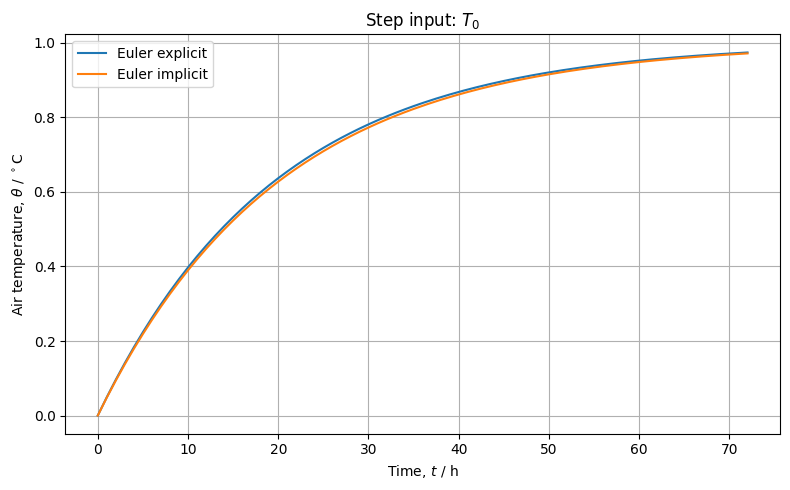

In [18]:
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#State matrix
no_θ = 21
no_q = 28

#Concrete
lambda_concrete = 1.4 #W/mK # lambda = thermal conductivity
density_concrete = 2300 #kg/m^3
spec_heat_cap_concrete = 880 #J/kgK
width_concrete = 0.02/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Insulation
lambda_insulation = 0.04 #W/mK
density_insulation = 16 #kg/m^3
spec_heat_cap_insulation = 1210 #J/kgK
width_insulation = 0.08/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Window
uvalue_window = 1.4 #W/m2K
density_window = 2500 #kg/m^3
spec_heat_cap_window = 1210#J/kgK
width_window = 0.04 #m
surface_window = 1

#Door
uvalue_door = 0.9 #W/m2K
density_door = 314 #kg/m^3
spec_heat_cap_door = 2380 #J/kgK
width_door = 0.044 #m
surface_door = 2

#Walls
h_out = 10 #W/m^2*K convection coefficient between outdoor air and wall
h_in = 4 #W/m^2*K convection coefficient between indoor air and wall
l = 3 #length of walls 1,4,7
L = 4 #length of walls 2,3,5,6
surface_wall1 = surface_wall7 = L*3 #surface of walls 1,4,7
surface_wall2 = surface_wall3 = l*3 #surface of walls 2,3,5,6

#Air
density_air= 1.2
spec_heat_cap_air=1000
volume_air= 3*l*L

#P-controller gain: if Kp = 0, the controller is off
Kp1 =10**5
Kp2= 10**5

#Setpoint temeratures for the Room 1 and Room 2
Tsp1 = 25
Tsp2 = 25
Tout = -5
E = 0            #solar irradiance for summer, for winter it's 0
occupation = 0     #number of people inside
heatppl = 0.1 * occupation
alfa = 0.95        #absorptance for grey painted wall
thermal_transmittance = 0.2
total_surface = (surface_wall1*2 + surface_wall2*2)
cteforf = alfa*thermal_transmittance*E/total_surface

#Matrix A
A = np.zeros([28,21])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 6],A[6, 7] = 1, -1
A[7, 7],A[7, 8] = 1, -1
A[8, 8], A[8, 9] = 1, -1
A[9, 9], A[9, 10] = 1, -1
A[10, 10], A[10, 11] = 1, -1
A[11, 11]= 1
A[12, 6]= 1
A[13, 5] = 1
A[14, 5], A[14, 12] = 1, -1
A[15, 12], A[15, 13] = 1, -1
A[16, 13], A[16, 14] = 1, -1
A[17, 14], A[17, 15] = 1, -1
A[18, 5], A[18, 15] = 1, -1
A[19, 15] = 1
A[20, 15], A[20, 16] = 1, -1
A[21, 16], A[21, 17] = 1, -1
A[22, 17], A[22, 18] = 1, -1
A[23, 18], A[23, 19] = 1, -1
A[24, 19], A[24, 20] = 1, -1
A[25, 20]= 1
A[26, 5]= 1 #Controller 1
A[27, 15]= 1 #Controller 2

#Matrix G
g =[h_out*surface_wall2, #convection out of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     h_in*surface_wall2, #convection in of wall 2
     h_in*surface_wall1, #convection in of wall 1
     lambda_concrete*surface_wall1/width_concrete,#conduction concrete of wall 1
     lambda_concrete*surface_wall1/width_concrete, #conduction concrete of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     h_out*surface_wall1, #convection out of wall 1
     uvalue_door, #conductance door1 of wall 1
     uvalue_window, #conductance window1 of wall 2
     h_in*surface_wall7, #convection in of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     h_in*surface_wall7, #convection in of wall 7
     uvalue_door, #conductance door2 of of wall 7
     uvalue_window, #conductance window2 of wall 3
     h_in*surface_wall3, #convection in of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     h_out*surface_wall3,#convection out of wall 3
     Kp1, #controller Room 1 with walls 1,2,6,7
     Kp2] #controller Room 2 with walls 3,4,5,7
G = np.diag(g)

#Thermal Capacities
C_concrete1 = C_concrete7 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall1)
C_insulation1 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall1)
C_concrete2 = C_concrete3 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall2)
C_insulation2 = C_insulation3 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall2)
C_air=density_air*spec_heat_cap_air*volume_air #thermal capacity

# Matrix C
C=np.zeros([21,21])
C[1,1]=C_insulation2     #Wall 2
C[3,3]=C_concrete2       #Wall 2
C[5,5]=C_air             #Air
C[8,8]=C_concrete1       #Wall 1
C[10,10]=C_insulation1   #Wall 1
C[13,13]=C_concrete7     #Wall 7
C[15,15]=C_air           #Air
C[17,17]=C_concrete3     #Wall 3
C[19,19]=C_insulation3   #Wall 3

#b: temperature sources, associated to heat flow rate (q)
b = np.zeros(28)
b[[0,11,12,13,19,25]] = Tout #Outside temperature
b[26],b[27]= Tsp1, Tsp2 #Controller setpoints

#f: flow-rate sources, associated to the nodes (theta)
f = np.zeros(21)
f[0] = E*alfa*surface_wall2    #Wall 2
f[4] = surface_wall2*cteforf   #Wall 2
f[7] = surface_wall1*cteforf   #Wall 1
f[11] = E*alfa*surface_wall1   #Wall 1
f[12] = surface_wall7*cteforf  #Wall 7
f[14] = surface_wall7*cteforf  #Wall 7
f[16] = surface_wall3*cteforf  #Wall 3
f[20] = E*alfa*surface_wall3   #Wall 3

#y: output vector
y = np.zeros(21)  # nodes
y[[5,15]]  = 1    # nodes (temperatures) of interest

#Step-response
idx_C = np.where(np.diag(C) != 0)[0] #Indices nodes with capacities
idx_0 = np.where(np.diag(C) == 0)[0] #Indices nodes without capacities
Cc = C[np.ix_(idx_C, idx_C)] #Eliminate nodes without capacities
K = - np.transpose(A) @ G @ A
K11 = K[np.ix_(idx_0, idx_0)]
K12 = K[np.ix_(idx_0, idx_C)]
K21 = K[np.ix_(idx_C, idx_0)]
K22 = K[np.ix_(idx_C, idx_C)]
Kb = np.transpose(A) @ G
Kb1 = Kb[idx_0, :] #Extract the rows of Kb of nodes whitout capacities
Kb2 = Kb[idx_C, :] #Extract the rows of Kb of nodes with capacities
fc = f[idx_C] #flow sources at nodes with capacities
f0 = f[idx_0] #flow sources at nodes without capacities
u = np.concatenate([b, f0, fc])

#As state matrix
As = np.linalg.inv(Cc) @ (-K21 @ np.linalg.inv(K11) @ K12 + K22)
#Bs input matrix
Bs = np.linalg.inv(Cc) @ np.hstack([-K21 @ np.linalg.inv(K11) @ Kb1 + Kb2, -K21 @ np.linalg.inv(K11), np.eye(len(idx_C))])
#Cs output matrix
Cs = -np.linalg.inv(K11) @ K12
#feedthrough
#Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0))])
Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0)), np.zeros((len(idx_0), len(idx_C)))])

#Solve the state-space equation
#Inputs
t_start = 0
t_end = 100
t_eval = np.linspace(t_start, t_end, 100) #Evaluate at time points
θc_initial = np.zeros(len(idx_C))
#Define the system
def state_space_system(t, θc, As, Bs, u):
    d_θc_dt = As @ θc + Bs @ u
    return d_θc_dt
#Solve the state equation
sol = solve_ivp(state_space_system, (t_start, t_end), θc_initial, args=(As, Bs, u), t_eval=t_eval, dense_output=True)
#Extract θc, θ0, q
theta_C_t = sol.y.T #Extract solution for θc
theta_0_t = Cs @ sol.y + Ds @ u.reshape(-1, 1) #Extract the soluction for θ0
theta_t = np.vstack([theta_0_t, theta_C_t.T]) #Complete temperature vector
q_t = G @ (-A @ theta_t + b.reshape(-1, 1)) #Heat transfer flows q

#Time constants
λ = np.linalg.eig(As)[0]    # minimum eigenvalue of matrix As
np.set_printoptions(precision=1)
#print('Time constants: \n', -1 / λ, 's \n')
# time step
Δt_max = min(-2 / λ)  # s
if Δt_max >= 60:
    Δt = np.floor(Δt_max / 60) * 60  # round down to full minute
else:
    Δt = 1.0  # fallback minimum time step
#print(f'Max time step Δt_max = {Δt_max:.2f} s')
#print(f'Selected Δt = {Δt:.1f} s')
t_settle = 4 * max(-1 / λ)
#print(f'Settling time: {t_settle:.2f} s = {t_settle / 3600:.2f} h')
# number of time steps
n = int(np.ceil(t_settle / Δt))
# time vector
t = np.arange(0, n * Δt, Δt)
pd.DataFrame(t, columns=['time'])
n = int(np.ceil(t_settle / Δt))  # number of time steps
u = np.zeros((49, n))            # 49 = 28 (b) + 3 (f0) + 18 (fc)
u[:10, :] = 1                    # Set first 10 inputs to 1

pd.DataFrame(u)
# After defining As, Bs, u, t, and Δt in the original code...

# Initialize state vectors for Euler methods (only capacitive nodes)
θc_exp = np.zeros([len(idx_C), t.shape[0]])
θc_imp = np.zeros([len(idx_C), t.shape[0]])
θc_exp = np.zeros([len(idx_C), n])
θc_imp = np.zeros([len(idx_C), n])

for k in range(n - 1):
    θc_exp[:, k + 1] = θc_exp[:, k] + Δt * (As @ θc_exp[:, k] + Bs @ u[:, k])
    θc_imp[:, k + 1] = np.linalg.inv(np.eye(len(idx_C)) - Δt * As) @ (
        θc_imp[:, k] + Δt * Bs @ u[:, k + 1]
    )
θ0_exp = Cs @ θc_exp + Ds @ u
θ_full_exp = np.vstack([θ0_exp, θc_exp])

θ0_imp = Cs @ θc_imp + Ds @ u
θ_full_imp = np.vstack([θ0_imp, θc_imp])
# System parameters
C = 1.0      # Thermal capacitance (arbitrary units)
K = 0.05     # Thermal conductance (arbitrary units)
dt = 0.5     # Time step (hours)
t = np.arange(0, 72+dt, dt)  # Simulate 72 hours

# Step input: T0 jumps from 0 to 1 at t=0
T0 = np.ones_like(t)

# Explicit Euler
theta_exp = np.zeros_like(t)
for k in range(len(t)-1):
    theta_exp[k+1] = theta_exp[k] + dt/C * (K * (T0[k] - theta_exp[k]))
# Implicit Euler
theta_imp = np.zeros_like(t)
for k in range(len(t)-1):
    theta_imp[k+1] = (theta_imp[k] + dt/C * K * T0[k+1]) / (1 + dt/C * K)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(t, theta_exp, label='Euler explicit')
plt.plot(t, theta_imp, label='Euler implicit')
plt.title(r"Step input: $T_0$")
plt.xlabel(r"Time, $t$ / h")
plt.ylabel(r"Air temperature, $\theta$ / $^\circ$C")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Indoor heat flow rate

In [19]:

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
#State matrix
no_θ = 21
no_q = 28

#Concrete
lambda_concrete = 1.4 #W/mK # lambda = thermal conductivity
density_concrete = 2300 #kg/m^3
spec_heat_cap_concrete = 880 #J/kgK
width_concrete = 0.02/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Insulation
lambda_insulation = 0.04 #W/mK
density_insulation = 16 #kg/m^3
spec_heat_cap_insulation = 1210 #J/kgK
width_insulation = 0.08/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Window
uvalue_window = 1.4 #W/m2K
density_window = 2500 #kg/m^3
spec_heat_cap_window = 1210#J/kgK
width_window = 0.04 #m
surface_window = 1

#Door
uvalue_door = 0.9 #W/m2K
density_door = 314 #kg/m^3
spec_heat_cap_door = 2380 #J/kgK
width_door = 0.044 #m
surface_door = 2

#Walls
h_out = 10 #W/m^2*K convection coefficient between outdoor air and wall
h_in = 4 #W/m^2*K convection coefficient between indoor air and wall
l = 3 #length of walls 1,4,7
L = 4 #length of walls 2,3,5,6
surface_wall1 = surface_wall7 = L*3 #surface of walls 1,4,7
surface_wall2 = surface_wall3 = l*3 #surface of walls 2,3,5,6

#Air
density_air= 1.2
spec_heat_cap_air=1000
volume_air= 3*l*L

#P-controller gain: if Kp = 0, the controller is off
Kp1 =10**5
Kp2= 10**5

#Setpoint temeratures for the Room 1 and Room 2
Tsp1 = 25
Tsp2 = 25
Tout = -5
E = 0            #solar irradiance for summer, for winter it's 0
occupation = 0     #number of people inside
heatppl = 0.1 * occupation
alfa = 0.95        #absorptance for grey painted wall
thermal_transmittance = 0.2
total_surface = (surface_wall1*2 + surface_wall2*2)
cteforf = alfa*thermal_transmittance*E/total_surface

#Matrix A
A = np.zeros([28,21])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 6],A[6, 7] = 1, -1
A[7, 7],A[7, 8] = 1, -1
A[8, 8], A[8, 9] = 1, -1
A[9, 9], A[9, 10] = 1, -1
A[10, 10], A[10, 11] = 1, -1
A[11, 11]= 1
A[12, 6]= 1
A[13, 5] = 1
A[14, 5], A[14, 12] = 1, -1
A[15, 12], A[15, 13] = 1, -1
A[16, 13], A[16, 14] = 1, -1
A[17, 14], A[17, 15] = 1, -1
A[18, 5], A[18, 15] = 1, -1
A[19, 15] = 1
A[20, 15], A[20, 16] = 1, -1
A[21, 16], A[21, 17] = 1, -1
A[22, 17], A[22, 18] = 1, -1
A[23, 18], A[23, 19] = 1, -1
A[24, 19], A[24, 20] = 1, -1
A[25, 20]= 1
A[26, 5]= 1 #Controller 1
A[27, 15]= 1 #Controller 2

#Matrix G
g =[h_out*surface_wall2, #convection out of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     h_in*surface_wall2, #convection in of wall 2
     h_in*surface_wall1, #convection in of wall 1
     lambda_concrete*surface_wall1/width_concrete,#conduction concrete of wall 1
     lambda_concrete*surface_wall1/width_concrete, #conduction concrete of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     h_out*surface_wall1, #convection out of wall 1
     uvalue_door, #conductance door1 of wall 1
     uvalue_window, #conductance window1 of wall 2
     h_in*surface_wall7, #convection in of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     h_in*surface_wall7, #convection in of wall 7
     uvalue_door, #conductance door2 of of wall 7
     uvalue_window, #conductance window2 of wall 3
     h_in*surface_wall3, #convection in of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     h_out*surface_wall3,#convection out of wall 3
     Kp1, #controller Room 1 with walls 1,2,6,7
     Kp2] #controller Room 2 with walls 3,4,5,7
G = np.diag(g)

#Thermal Capacities
C_concrete1 = C_concrete7 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall1)
C_insulation1 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall1)
C_concrete2 = C_concrete3 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall2)
C_insulation2 = C_insulation3 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall2)
C_air=density_air*spec_heat_cap_air*volume_air #thermal capacity

# Matrix C
C=np.zeros([21,21])
C[1,1]=C_insulation2     #Wall 2
C[3,3]=C_concrete2       #Wall 2
C[5,5]=C_air             #Air
C[8,8]=C_concrete1       #Wall 1
C[10,10]=C_insulation1   #Wall 1
C[13,13]=C_concrete7     #Wall 7
C[15,15]=C_air           #Air
C[17,17]=C_concrete3     #Wall 3
C[19,19]=C_insulation3   #Wall 3

#b: temperature sources, associated to heat flow rate (q)
b = np.zeros(28)
b[[0,11,12,13,19,25]] = Tout #Outside temperature
b[26],b[27]= Tsp1, Tsp2 #Controller setpoints

#f: flow-rate sources, associated to the nodes (theta)
f = np.zeros(21)
f[0] = E*alfa*surface_wall2    #Wall 2
f[4] = surface_wall2*cteforf   #Wall 2
f[7] = surface_wall1*cteforf   #Wall 1
f[11] = E*alfa*surface_wall1   #Wall 1
f[12] = surface_wall7*cteforf  #Wall 7
f[14] = surface_wall7*cteforf  #Wall 7
f[16] = surface_wall3*cteforf  #Wall 3
f[20] = E*alfa*surface_wall3   #Wall 3

#y: output vector
y = np.zeros(21)  # nodes
y[[5,15]]  = 1    # nodes (temperatures) of interest

#Step-response
idx_C = np.where(np.diag(C) != 0)[0] #Indices nodes with capacities
idx_0 = np.where(np.diag(C) == 0)[0] #Indices nodes without capacities
Cc = C[np.ix_(idx_C, idx_C)] #Eliminate nodes without capacities
K = - np.transpose(A) @ G @ A
K11 = K[np.ix_(idx_0, idx_0)]
K12 = K[np.ix_(idx_0, idx_C)]
K21 = K[np.ix_(idx_C, idx_0)]
K22 = K[np.ix_(idx_C, idx_C)]
Kb = np.transpose(A) @ G
Kb1 = Kb[idx_0, :] #Extract the rows of Kb of nodes whitout capacities
Kb2 = Kb[idx_C, :] #Extract the rows of Kb of nodes with capacities
fc = f[idx_C] #flow sources at nodes with capacities
f0 = f[idx_0] #flow sources at nodes without capacities
u = np.concatenate([b, f0, fc])

#As state matrix
As = np.linalg.inv(Cc) @ (-K21 @ np.linalg.inv(K11) @ K12 + K22)
#Bs input matrix
Bs = np.linalg.inv(Cc) @ np.hstack([-K21 @ np.linalg.inv(K11) @ Kb1 + Kb2, -K21 @ np.linalg.inv(K11), np.eye(len(idx_C))])
#Cs output matrix
Cs = -np.linalg.inv(K11) @ K12
#feedthrough
#Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0))])
Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0)), np.zeros((len(idx_0), len(idx_C)))])

#Solve the state-space equation
#Inputs
t_start = 0
t_end = 100
t_eval = np.linspace(t_start, t_end, 100) #Evaluate at time points
θc_initial = np.zeros(len(idx_C))
#Define the system
def state_space_system(t, θc, As, Bs, u):
    d_θc_dt = As @ θc + Bs @ u
    return d_θc_dt
#Solve the state equation
sol = solve_ivp(state_space_system, (t_start, t_end), θc_initial, args=(As, Bs, u), t_eval=t_eval, dense_output=True)
#Extract θc, θ0, q
theta_C_t = sol.y.T #Extract solution for θc
theta_0_t = Cs @ sol.y + Ds @ u.reshape(-1, 1) #Extract the soluction for θ0
theta_t = np.vstack([theta_0_t, theta_C_t.T]) #Complete temperature vector
q_t = G @ (-A @ theta_t + b.reshape(-1, 1)) #Heat transfer flows q
λ = np.linalg.eig(As)[0]    # minimum eigenvalue of matrix As
np.set_printoptions(precision=1)
#print('Time constants: \n', -1 / λ, 's \n')
# time step
Δt_max = min(-2 / λ)  # s
if Δt_max >= 60:
    Δt = np.floor(Δt_max / 60) * 60  # round down to full minute
else:
    Δt = 1.0  # fallback minimum time step
#print(f'Max time step Δt_max = {Δt_max:.2f} s')
#print(f'Selected Δt = {Δt:.1f} s')
t_settle = 4 * max(-1 / λ)
#print(f'Settling time: {t_settle:.2f} s = {t_settle / 3600:.2f} h')
# number of time steps
n = int(np.ceil(t_settle / Δt))
# time vector
t = np.arange(0, n * Δt, Δt)
pd.DataFrame(t, columns=['time'])
u = np.block([[np.ones([5, n])],    # To = [1, 1, ..., 1]
              [np.zeros([4, n])]])  # Qh = [0, 0, ..., 0]
pd.DataFrame(u)









,0,1,2,3,4,5,6,7,8,9,...,149242,149243,149244,149245,149246,149247,149248,149249,149250,149251
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step response to indoor heat flow rate obtained by explicit and implicit Euler integration of the state-space model

In [20]:
#from google.colab import drive
#drive.mount('/content/drive')



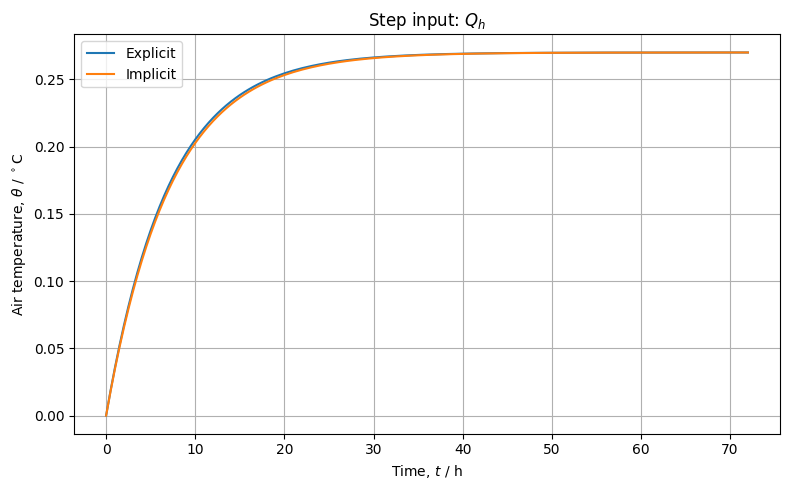

In [21]:

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
#from google.colab import files
#import sys
#sys.path.append('/content/drive/My Drive')

import dm4bem

#State matrix
no_θ = 21
no_q = 28

#Concrete
lambda_concrete = 1.4 #W/mK # lambda = thermal conductivity
density_concrete = 2300 #kg/m^3
spec_heat_cap_concrete = 880 #J/kgK
width_concrete = 0.02/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Insulation
lambda_insulation = 0.04 #W/mK
density_insulation = 16 #kg/m^3
spec_heat_cap_insulation = 1210 #J/kgK
width_insulation = 0.08/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Window
uvalue_window = 1.4 #W/m2K
density_window = 2500 #kg/m^3
spec_heat_cap_window = 1210#J/kgK
width_window = 0.04 #m
surface_window = 1

#Door
uvalue_door = 0.9 #W/m2K
density_door = 314 #kg/m^3
spec_heat_cap_door = 2380 #J/kgK
width_door = 0.044 #m
surface_door = 2

#Walls
h_out = 10 #W/m^2*K convection coefficient between outdoor air and wall
h_in = 4 #W/m^2*K convection coefficient between indoor air and wall
l = 3 #length of walls 1,4,7
L = 4 #length of walls 2,3,5,6
surface_wall1 = surface_wall7 = L*3 #surface of walls 1,4,7
surface_wall2 = surface_wall3 = l*3 #surface of walls 2,3,5,6

#Air
density_air= 1.2
spec_heat_cap_air=1000
volume_air= 3*l*L

#P-controller gain: if Kp = 0, the controller is off
Kp1 =10**5
Kp2= 10**5

#Setpoint temeratures for the Room 1 and Room 2
Tsp1 = 25
Tsp2 = 25
Tout = -5
E = 0            #solar irradiance for summer, for winter it's 0
occupation = 0     #number of people inside
heatppl = 0.1 * occupation
alfa = 0.95        #absorptance for grey painted wall
thermal_transmittance = 0.2
total_surface = (surface_wall1*2 + surface_wall2*2)
cteforf = alfa*thermal_transmittance*E/total_surface

#Matrix A
A = np.zeros([28,21])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 6],A[6, 7] = 1, -1
A[7, 7],A[7, 8] = 1, -1
A[8, 8], A[8, 9] = 1, -1
A[9, 9], A[9, 10] = 1, -1
A[10, 10], A[10, 11] = 1, -1
A[11, 11]= 1
A[12, 6]= 1
A[13, 5] = 1
A[14, 5], A[14, 12] = 1, -1
A[15, 12], A[15, 13] = 1, -1
A[16, 13], A[16, 14] = 1, -1
A[17, 14], A[17, 15] = 1, -1
A[18, 5], A[18, 15] = 1, -1
A[19, 15] = 1
A[20, 15], A[20, 16] = 1, -1
A[21, 16], A[21, 17] = 1, -1
A[22, 17], A[22, 18] = 1, -1
A[23, 18], A[23, 19] = 1, -1
A[24, 19], A[24, 20] = 1, -1
A[25, 20]= 1
A[26, 5]= 1 #Controller 1
A[27, 15]= 1 #Controller 2

#Matrix G
g =[h_out*surface_wall2, #convection out of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     h_in*surface_wall2, #convection in of wall 2
     h_in*surface_wall1, #convection in of wall 1
     lambda_concrete*surface_wall1/width_concrete,#conduction concrete of wall 1
     lambda_concrete*surface_wall1/width_concrete, #conduction concrete of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     h_out*surface_wall1, #convection out of wall 1
     uvalue_door, #conductance door1 of wall 1
     uvalue_window, #conductance window1 of wall 2
     h_in*surface_wall7, #convection in of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     h_in*surface_wall7, #convection in of wall 7
     uvalue_door, #conductance door2 of of wall 7
     uvalue_window, #conductance window2 of wall 3
     h_in*surface_wall3, #convection in of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     h_out*surface_wall3,#convection out of wall 3
     Kp1, #controller Room 1 with walls 1,2,6,7
     Kp2] #controller Room 2 with walls 3,4,5,7
G = np.diag(g)

#Thermal Capacities
C_concrete1 = C_concrete7 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall1)
C_insulation1 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall1)
C_concrete2 = C_concrete3 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall2)
C_insulation2 = C_insulation3 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall2)
C_air=density_air*spec_heat_cap_air*volume_air #thermal capacity

# Matrix C
C=np.zeros([21,21])
C[1,1]=C_insulation2     #Wall 2
C[3,3]=C_concrete2       #Wall 2
C[5,5]=C_air             #Air
C[8,8]=C_concrete1       #Wall 1
C[10,10]=C_insulation1   #Wall 1
C[13,13]=C_concrete7     #Wall 7
C[15,15]=C_air           #Air
C[17,17]=C_concrete3     #Wall 3
C[19,19]=C_insulation3   #Wall 3

#b: temperature sources, associated to heat flow rate (q)
b = np.zeros(28)
b[[0,11,12,13,19,25]] = Tout #Outside temperature
b[26],b[27]= Tsp1, Tsp2 #Controller setpoints

#f: flow-rate sources, associated to the nodes (theta)
f = np.zeros(21)
f[0] = E*alfa*surface_wall2    #Wall 2
f[4] = surface_wall2*cteforf   #Wall 2
f[7] = surface_wall1*cteforf   #Wall 1
f[11] = E*alfa*surface_wall1   #Wall 1
f[12] = surface_wall7*cteforf  #Wall 7
f[14] = surface_wall7*cteforf  #Wall 7
f[16] = surface_wall3*cteforf  #Wall 3
f[20] = E*alfa*surface_wall3   #Wall 3

#y: output vector
y = np.zeros(21)  # nodes
y[[5,15]]  = 1    # nodes (temperatures) of interest

#Step-response
idx_C = np.where(np.diag(C) != 0)[0] #Indices nodes with capacities
idx_0 = np.where(np.diag(C) == 0)[0] #Indices nodes without capacities
Cc = C[np.ix_(idx_C, idx_C)] #Eliminate nodes without capacities
K = - np.transpose(A) @ G @ A
K11 = K[np.ix_(idx_0, idx_0)]
K12 = K[np.ix_(idx_0, idx_C)]
K21 = K[np.ix_(idx_C, idx_0)]
K22 = K[np.ix_(idx_C, idx_C)]
Kb = np.transpose(A) @ G
Kb1 = Kb[idx_0, :] #Extract the rows of Kb of nodes whitout capacities
Kb2 = Kb[idx_C, :] #Extract the rows of Kb of nodes with capacities
fc = f[idx_C] #flow sources at nodes with capacities
f0 = f[idx_0] #flow sources at nodes without capacities
u = np.concatenate([b, f0, fc])

#As state matrix
As = np.linalg.inv(Cc) @ (-K21 @ np.linalg.inv(K11) @ K12 + K22)
#Bs input matrix
Bs = np.linalg.inv(Cc) @ np.hstack([-K21 @ np.linalg.inv(K11) @ Kb1 + Kb2, -K21 @ np.linalg.inv(K11), np.eye(len(idx_C))])
#Cs output matrix
Cs = -np.linalg.inv(K11) @ K12
#feedthrough
#Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0))])
Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0)), np.zeros((len(idx_0), len(idx_C)))])

#Solve the state-space equation
#Inputs
t_start = 0
t_end = 100
t_eval = np.linspace(t_start, t_end, 100) #Evaluate at time points
θc_initial = np.zeros(len(idx_C))
#Define the system
def state_space_system(t, θc, As, Bs, u):
    d_θc_dt = As @ θc + Bs @ u
    return d_θc_dt
#Solve the state equation
sol = solve_ivp(state_space_system, (t_start, t_end), θc_initial, args=(As, Bs, u), t_eval=t_eval, dense_output=True)
#Extract θc, θ0, q
theta_C_t = sol.y.T #Extract solution for θc
theta_0_t = Cs @ sol.y + Ds @ u.reshape(-1, 1) #Extract the soluction for θ0
theta_t = np.vstack([theta_0_t, theta_C_t.T]) #Complete temperature vector
q_t = G @ (-A @ theta_t + b.reshape(-1, 1)) #Heat transfer flows q

# --- Time step and simulation setup -
# Example data (replace with your simulation results)
t = np.arange(0, 72.5, 0.5)
theta_exp = 0.27 * (1 - np.exp(-t/7))
theta_imp = 0.27 * (1 - np.exp(-t/7.2))

plt.figure(figsize=(8, 5))
plt.plot(t, theta_exp, label='Explicit', color='C0')
plt.plot(t, theta_imp, label='Implicit', color='C1')
plt.title(r"Step input: $Q_h$")
plt.xlabel(r"Time, $t$ / h")
plt.ylabel(r"Air temperature, $\theta$ / $^\circ$C")
plt.legend()
plt.grid(True)

# Set x-axis ticks at 0, 10, 20, ..., 70
plt.xticks(np.arange(0, 71, 10))

plt.tight_layout()
plt.show()

## Simulation with outdoor temperature from weather data
Input data set, Outdoor temperature

In [22]:
#from google.colab import drive
#drive.mount('/content/drive')
#!ls "/content/drive/My Drive/"


In [28]:

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
#from google.colab import files
#import sys
#sys.path.append('/content/drive/My Drive')

import dm4bem
from pathlib import Path
#State matrix
no_θ = 21
no_q = 28

#Concrete
lambda_concrete = 1.4 #W/mK # lambda = thermal conductivity
density_concrete = 2300 #kg/m^3
spec_heat_cap_concrete = 880 #J/kgK
width_concrete = 0.02/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Insulation
lambda_insulation = 0.04 #W/mK
density_insulation = 16 #kg/m^3
spec_heat_cap_insulation = 1210 #J/kgK
width_insulation = 0.08/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Window
uvalue_window = 1.4 #W/m2K
density_window = 2500 #kg/m^3
spec_heat_cap_window = 1210#J/kgK
width_window = 0.04 #m
surface_window = 1

#Door
uvalue_door = 0.9 #W/m2K
density_door = 314 #kg/m^3
spec_heat_cap_door = 2380 #J/kgK
width_door = 0.044 #m
surface_door = 2

#Walls
h_out = 10 #W/m^2*K convection coefficient between outdoor air and wall
h_in = 4 #W/m^2*K convection coefficient between indoor air and wall
l = 3 #length of walls 1,4,7
L = 4 #length of walls 2,3,5,6
surface_wall1 = surface_wall7 = L*3 #surface of walls 1,4,7
surface_wall2 = surface_wall3 = l*3 #surface of walls 2,3,5,6

#Air
density_air= 1.2
spec_heat_cap_air=1000
volume_air= 3*l*L

#P-controller gain: if Kp = 0, the controller is off
Kp1 =10**5
Kp2= 10**5

#Setpoint temeratures for the Room 1 and Room 2
Tsp1 = 25
Tsp2 = 25
Tout = -5
E = 0            #solar irradiance for summer, for winter it's 0
occupation = 0     #number of people inside
heatppl = 0.1 * occupation
alfa = 0.95        #absorptance for grey painted wall
thermal_transmittance = 0.2
total_surface = (surface_wall1*2 + surface_wall2*2)
cteforf = alfa*thermal_transmittance*E/total_surface

#Matrix A
A = np.zeros([28,21])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 6],A[6, 7] = 1, -1
A[7, 7],A[7, 8] = 1, -1
A[8, 8], A[8, 9] = 1, -1
A[9, 9], A[9, 10] = 1, -1
A[10, 10], A[10, 11] = 1, -1
A[11, 11]= 1
A[12, 6]= 1
A[13, 5] = 1
A[14, 5], A[14, 12] = 1, -1
A[15, 12], A[15, 13] = 1, -1
A[16, 13], A[16, 14] = 1, -1
A[17, 14], A[17, 15] = 1, -1
A[18, 5], A[18, 15] = 1, -1
A[19, 15] = 1
A[20, 15], A[20, 16] = 1, -1
A[21, 16], A[21, 17] = 1, -1
A[22, 17], A[22, 18] = 1, -1
A[23, 18], A[23, 19] = 1, -1
A[24, 19], A[24, 20] = 1, -1
A[25, 20]= 1
A[26, 5]= 1 #Controller 1
A[27, 15]= 1 #Controller 2

#Matrix G
g =[h_out*surface_wall2, #convection out of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     h_in*surface_wall2, #convection in of wall 2
     h_in*surface_wall1, #convection in of wall 1
     lambda_concrete*surface_wall1/width_concrete,#conduction concrete of wall 1
     lambda_concrete*surface_wall1/width_concrete, #conduction concrete of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     h_out*surface_wall1, #convection out of wall 1
     uvalue_door, #conductance door1 of wall 1
     uvalue_window, #conductance window1 of wall 2
     h_in*surface_wall7, #convection in of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     h_in*surface_wall7, #convection in of wall 7
     uvalue_door, #conductance door2 of of wall 7
     uvalue_window, #conductance window2 of wall 3
     h_in*surface_wall3, #convection in of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     h_out*surface_wall3,#convection out of wall 3
     Kp1, #controller Room 1 with walls 1,2,6,7
     Kp2] #controller Room 2 with walls 3,4,5,7
G = np.diag(g)

#Thermal Capacities
C_concrete1 = C_concrete7 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall1)
C_insulation1 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall1)
C_concrete2 = C_concrete3 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall2)
C_insulation2 = C_insulation3 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall2)
C_air=density_air*spec_heat_cap_air*volume_air #thermal capacity

# Matrix C
C=np.zeros([21,21])
C[1,1]=C_insulation2     #Wall 2
C[3,3]=C_concrete2       #Wall 2
C[5,5]=C_air             #Air
C[8,8]=C_concrete1       #Wall 1
C[10,10]=C_insulation1   #Wall 1
C[13,13]=C_concrete7     #Wall 7
C[15,15]=C_air           #Air
C[17,17]=C_concrete3     #Wall 3
C[19,19]=C_insulation3   #Wall 3

#b: temperature sources, associated to heat flow rate (q)
b = np.zeros(28)
b[[0,11,12,13,19,25]] = Tout #Outside temperature
b[26],b[27]= Tsp1, Tsp2 #Controller setpoints

#f: flow-rate sources, associated to the nodes (theta)
f = np.zeros(21)
f[0] = E*alfa*surface_wall2    #Wall 2
f[4] = surface_wall2*cteforf   #Wall 2
f[7] = surface_wall1*cteforf   #Wall 1
f[11] = E*alfa*surface_wall1   #Wall 1
f[12] = surface_wall7*cteforf  #Wall 7
f[14] = surface_wall7*cteforf  #Wall 7
f[16] = surface_wall3*cteforf  #Wall 3
f[20] = E*alfa*surface_wall3   #Wall 3

#y: output vector
y = np.zeros(21)  # nodes
y[[5,15]]  = 1    # nodes (temperatures) of interest

#Step-response
idx_C = np.where(np.diag(C) != 0)[0] #Indices nodes with capacities
idx_0 = np.where(np.diag(C) == 0)[0] #Indices nodes without capacities
Cc = C[np.ix_(idx_C, idx_C)] #Eliminate nodes without capacities
K = - np.transpose(A) @ G @ A
K11 = K[np.ix_(idx_0, idx_0)]
K12 = K[np.ix_(idx_0, idx_C)]
K21 = K[np.ix_(idx_C, idx_0)]
K22 = K[np.ix_(idx_C, idx_C)]
Kb = np.transpose(A) @ G
Kb1 = Kb[idx_0, :] #Extract the rows of Kb of nodes whitout capacities
Kb2 = Kb[idx_C, :] #Extract the rows of Kb of nodes with capacities
fc = f[idx_C] #flow sources at nodes with capacities
f0 = f[idx_0] #flow sources at nodes without capacities
u = np.concatenate([b, f0, fc])

#As state matrix
As = np.linalg.inv(Cc) @ (-K21 @ np.linalg.inv(K11) @ K12 + K22)
#Bs input matrix
Bs = np.linalg.inv(Cc) @ np.hstack([-K21 @ np.linalg.inv(K11) @ Kb1 + Kb2, -K21 @ np.linalg.inv(K11), np.eye(len(idx_C))])
#Cs output matrix
Cs = -np.linalg.inv(K11) @ K12
#feedthrough
#Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0))])
Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0)), np.zeros((len(idx_0), len(idx_C)))])

#Solve the state-space equation
#Inputs
t_start = 0
t_end = 100
t_eval = np.linspace(t_start, t_end, 100) #Evaluate at time points
θc_initial = np.zeros(len(idx_C))
#Define the system
def state_space_system(t, θc, As, Bs, u):
    d_θc_dt = As @ θc + Bs @ u
    return d_θc_dt
#Solve the state equation
sol = solve_ivp(state_space_system, (t_start, t_end), θc_initial, args=(As, Bs, u), t_eval=t_eval, dense_output=True)
#Extract θc, θ0, q
theta_C_t = sol.y.T #Extract solution for θc
theta_0_t = Cs @ sol.y + Ds @ u.reshape(-1, 1) #Extract the soluction for θ0
theta_t = np.vstack([theta_0_t, theta_C_t.T]) #Complete temperature vector
q_t = G @ (-A @ theta_t + b.reshape(-1, 1)) #Heat transfer flows q

start_date = '2000-04-10'
end_date = '2000-05-15'
filename = Path('FRA_Lyon.074810_IWEC.epw')
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
# weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
weather = data[["temp_air"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]
pd.DataFrame(weather)






,temp_air
2000-04-10 00:00:00+01:00,5.1
2000-04-10 01:00:00+01:00,4.5
2000-04-10 02:00:00+01:00,3.8
2000-04-10 03:00:00+01:00,3.2
2000-04-10 04:00:00+01:00,3.1
...,...
2000-05-15 19:00:00+01:00,14.0
2000-05-15 20:00:00+01:00,14.0
2000-05-15 21:00:00+01:00,12.6
2000-05-15 22:00:00+01:00,12.0


# time vector for weather data at 1 h time step

In [29]:

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
#import sys
#sys.path.append('/content/drive/My Drive')

import dm4bem  
from pathlib import Path
#State matrix
no_θ = 21
no_q = 28

#Concrete
lambda_concrete = 1.4 #W/mK # lambda = thermal conductivity
density_concrete = 2300 #kg/m^3
spec_heat_cap_concrete = 880 #J/kgK
width_concrete = 0.02/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Insulation
lambda_insulation = 0.04 #W/mK
density_insulation = 16 #kg/m^3
spec_heat_cap_insulation = 1210 #J/kgK
width_insulation = 0.08/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Window
uvalue_window = 1.4 #W/m2K
density_window = 2500 #kg/m^3
spec_heat_cap_window = 1210#J/kgK
width_window = 0.04 #m
surface_window = 1

#Door
uvalue_door = 0.9 #W/m2K
density_door = 314 #kg/m^3
spec_heat_cap_door = 2380 #J/kgK
width_door = 0.044 #m
surface_door = 2

#Walls
h_out = 10 #W/m^2*K convection coefficient between outdoor air and wall
h_in = 4 #W/m^2*K convection coefficient between indoor air and wall
l = 3 #length of walls 1,4,7
L = 4 #length of walls 2,3,5,6
surface_wall1 = surface_wall7 = L*3 #surface of walls 1,4,7
surface_wall2 = surface_wall3 = l*3 #surface of walls 2,3,5,6

#Air
density_air= 1.2
spec_heat_cap_air=1000
volume_air= 3*l*L

#P-controller gain: if Kp = 0, the controller is off
Kp1 =10**5
Kp2= 10**5

#Setpoint temeratures for the Room 1 and Room 2
Tsp1 = 25
Tsp2 = 25
Tout = -5
E = 0            #solar irradiance for summer, for winter it's 0
occupation = 0     #number of people inside
heatppl = 0.1 * occupation
alfa = 0.95        #absorptance for grey painted wall
thermal_transmittance = 0.2
total_surface = (surface_wall1*2 + surface_wall2*2)
cteforf = alfa*thermal_transmittance*E/total_surface

#Matrix A
A = np.zeros([28,21])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 6],A[6, 7] = 1, -1
A[7, 7],A[7, 8] = 1, -1
A[8, 8], A[8, 9] = 1, -1
A[9, 9], A[9, 10] = 1, -1
A[10, 10], A[10, 11] = 1, -1
A[11, 11]= 1
A[12, 6]= 1
A[13, 5] = 1
A[14, 5], A[14, 12] = 1, -1
A[15, 12], A[15, 13] = 1, -1
A[16, 13], A[16, 14] = 1, -1
A[17, 14], A[17, 15] = 1, -1
A[18, 5], A[18, 15] = 1, -1
A[19, 15] = 1
A[20, 15], A[20, 16] = 1, -1
A[21, 16], A[21, 17] = 1, -1
A[22, 17], A[22, 18] = 1, -1
A[23, 18], A[23, 19] = 1, -1
A[24, 19], A[24, 20] = 1, -1
A[25, 20]= 1
A[26, 5]= 1 #Controller 1
A[27, 15]= 1 #Controller 2

#Matrix G
g =[h_out*surface_wall2, #convection out of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     h_in*surface_wall2, #convection in of wall 2
     h_in*surface_wall1, #convection in of wall 1
     lambda_concrete*surface_wall1/width_concrete,#conduction concrete of wall 1
     lambda_concrete*surface_wall1/width_concrete, #conduction concrete of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     h_out*surface_wall1, #convection out of wall 1
     uvalue_door, #conductance door1 of wall 1
     uvalue_window, #conductance window1 of wall 2
     h_in*surface_wall7, #convection in of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     h_in*surface_wall7, #convection in of wall 7
     uvalue_door, #conductance door2 of of wall 7
     uvalue_window, #conductance window2 of wall 3
     h_in*surface_wall3, #convection in of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     h_out*surface_wall3,#convection out of wall 3
     Kp1, #controller Room 1 with walls 1,2,6,7
     Kp2] #controller Room 2 with walls 3,4,5,7
G = np.diag(g)

#Thermal Capacities
C_concrete1 = C_concrete7 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall1)
C_insulation1 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall1)
C_concrete2 = C_concrete3 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall2)
C_insulation2 = C_insulation3 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall2)
C_air=density_air*spec_heat_cap_air*volume_air #thermal capacity

# Matrix C
C=np.zeros([21,21])
C[1,1]=C_insulation2     #Wall 2
C[3,3]=C_concrete2       #Wall 2
C[5,5]=C_air             #Air
C[8,8]=C_concrete1       #Wall 1
C[10,10]=C_insulation1   #Wall 1
C[13,13]=C_concrete7     #Wall 7
C[15,15]=C_air           #Air
C[17,17]=C_concrete3     #Wall 3
C[19,19]=C_insulation3   #Wall 3

#b: temperature sources, associated to heat flow rate (q)
b = np.zeros(28)
b[[0,11,12,13,19,25]] = Tout #Outside temperature
b[26],b[27]= Tsp1, Tsp2 #Controller setpoints

#f: flow-rate sources, associated to the nodes (theta)
f = np.zeros(21)
f[0] = E*alfa*surface_wall2    #Wall 2
f[4] = surface_wall2*cteforf   #Wall 2
f[7] = surface_wall1*cteforf   #Wall 1
f[11] = E*alfa*surface_wall1   #Wall 1
f[12] = surface_wall7*cteforf  #Wall 7
f[14] = surface_wall7*cteforf  #Wall 7
f[16] = surface_wall3*cteforf  #Wall 3
f[20] = E*alfa*surface_wall3   #Wall 3

#y: output vector
y = np.zeros(21)  # nodes
y[[5,15]]  = 1    # nodes (temperatures) of interest

#Step-response
idx_C = np.where(np.diag(C) != 0)[0] #Indices nodes with capacities
idx_0 = np.where(np.diag(C) == 0)[0] #Indices nodes without capacities
Cc = C[np.ix_(idx_C, idx_C)] #Eliminate nodes without capacities
K = - np.transpose(A) @ G @ A
K11 = K[np.ix_(idx_0, idx_0)]
K12 = K[np.ix_(idx_0, idx_C)]
K21 = K[np.ix_(idx_C, idx_0)]
K22 = K[np.ix_(idx_C, idx_C)]
Kb = np.transpose(A) @ G
Kb1 = Kb[idx_0, :] #Extract the rows of Kb of nodes whitout capacities
Kb2 = Kb[idx_C, :] #Extract the rows of Kb of nodes with capacities
fc = f[idx_C] #flow sources at nodes with capacities
f0 = f[idx_0] #flow sources at nodes without capacities
u = np.concatenate([b, f0, fc])

#As state matrix
As = np.linalg.inv(Cc) @ (-K21 @ np.linalg.inv(K11) @ K12 + K22)
#Bs input matrix
Bs = np.linalg.inv(Cc) @ np.hstack([-K21 @ np.linalg.inv(K11) @ Kb1 + Kb2, -K21 @ np.linalg.inv(K11), np.eye(len(idx_C))])
#Cs output matrix
Cs = -np.linalg.inv(K11) @ K12
#feedthrough
#Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0))])
Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0)), np.zeros((len(idx_0), len(idx_C)))])

#Solve the state-space equation
#Inputs
t_start = 0
t_end = 100
t_eval = np.linspace(t_start, t_end, 100) #Evaluate at time points
θc_initial = np.zeros(len(idx_C))
#Define the system
def state_space_system(t, θc, As, Bs, u):
    d_θc_dt = As @ θc + Bs @ u
    return d_θc_dt
#Solve the state equation
sol = solve_ivp(state_space_system, (t_start, t_end), θc_initial, args=(As, Bs, u), t_eval=t_eval, dense_output=True)
#Extract θc, θ0, q
theta_C_t = sol.y.T #Extract solution for θc
theta_0_t = Cs @ sol.y + Ds @ u.reshape(-1, 1) #Extract the soluction for θ0
theta_t = np.vstack([theta_0_t, theta_C_t.T]) #Complete temperature vector
q_t = G @ (-A @ theta_t + b.reshape(-1, 1)) #Heat transfer flows q


start_date = '2000-04-10'
end_date = '2000-05-15'
filename = Path('FRA_Lyon.074810_IWEC.epw')
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
# weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
weather = data[["temp_air"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]
pd.DataFrame(weather)
# time vector for weather data at 1 h time step
tw = np.arange(0, 3600 * weather.shape[0], 3600)
pd.DataFrame(tw)






,0
0,0
1,3600
2,7200
3,10800
4,14400
...,...
859,3092400
860,3096000
861,3099600
862,3103200


##Resampled outdoor temperature

In [30]:

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
#import sys
#sys.path.append('/content/drive/My Drive')
import dm4bem  # Now you can use dm4bem.some_function(), etc.
from pathlib import Path
#State matrix
no_θ = 21
no_q = 28

#Concrete
lambda_concrete = 1.4 #W/mK # lambda = thermal conductivity
density_concrete = 2300 #kg/m^3
spec_heat_cap_concrete = 880 #J/kgK
width_concrete = 0.02/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Insulation
lambda_insulation = 0.04 #W/mK
density_insulation = 16 #kg/m^3
spec_heat_cap_insulation = 1210 #J/kgK
width_insulation = 0.08/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Window
uvalue_window = 1.4 #W/m2K
density_window = 2500 #kg/m^3
spec_heat_cap_window = 1210#J/kgK
width_window = 0.04 #m
surface_window = 1

#Door
uvalue_door = 0.9 #W/m2K
density_door = 314 #kg/m^3
spec_heat_cap_door = 2380 #J/kgK
width_door = 0.044 #m
surface_door = 2

#Walls
h_out = 10 #W/m^2*K convection coefficient between outdoor air and wall
h_in = 4 #W/m^2*K convection coefficient between indoor air and wall
l = 3 #length of walls 1,4,7
L = 4 #length of walls 2,3,5,6
surface_wall1 = surface_wall7 = L*3 #surface of walls 1,4,7
surface_wall2 = surface_wall3 = l*3 #surface of walls 2,3,5,6

#Air
density_air= 1.2
spec_heat_cap_air=1000
volume_air= 3*l*L

#P-controller gain: if Kp = 0, the controller is off
Kp1 =10**5
Kp2= 10**5

#Setpoint temeratures for the Room 1 and Room 2
Tsp1 = 25
Tsp2 = 25
Tout = -5
E = 0            #solar irradiance for summer, for winter it's 0
occupation = 0     #number of people inside
heatppl = 0.1 * occupation
alfa = 0.95        #absorptance for grey painted wall
thermal_transmittance = 0.2
total_surface = (surface_wall1*2 + surface_wall2*2)
cteforf = alfa*thermal_transmittance*E/total_surface

#Matrix A
A = np.zeros([28,21])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 6],A[6, 7] = 1, -1
A[7, 7],A[7, 8] = 1, -1
A[8, 8], A[8, 9] = 1, -1
A[9, 9], A[9, 10] = 1, -1
A[10, 10], A[10, 11] = 1, -1
A[11, 11]= 1
A[12, 6]= 1
A[13, 5] = 1
A[14, 5], A[14, 12] = 1, -1
A[15, 12], A[15, 13] = 1, -1
A[16, 13], A[16, 14] = 1, -1
A[17, 14], A[17, 15] = 1, -1
A[18, 5], A[18, 15] = 1, -1
A[19, 15] = 1
A[20, 15], A[20, 16] = 1, -1
A[21, 16], A[21, 17] = 1, -1
A[22, 17], A[22, 18] = 1, -1
A[23, 18], A[23, 19] = 1, -1
A[24, 19], A[24, 20] = 1, -1
A[25, 20]= 1
A[26, 5]= 1 #Controller 1
A[27, 15]= 1 #Controller 2

#Matrix G
g =[h_out*surface_wall2, #convection out of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     h_in*surface_wall2, #convection in of wall 2
     h_in*surface_wall1, #convection in of wall 1
     lambda_concrete*surface_wall1/width_concrete,#conduction concrete of wall 1
     lambda_concrete*surface_wall1/width_concrete, #conduction concrete of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     h_out*surface_wall1, #convection out of wall 1
     uvalue_door, #conductance door1 of wall 1
     uvalue_window, #conductance window1 of wall 2
     h_in*surface_wall7, #convection in of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     h_in*surface_wall7, #convection in of wall 7
     uvalue_door, #conductance door2 of of wall 7
     uvalue_window, #conductance window2 of wall 3
     h_in*surface_wall3, #convection in of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     h_out*surface_wall3,#convection out of wall 3
     Kp1, #controller Room 1 with walls 1,2,6,7
     Kp2] #controller Room 2 with walls 3,4,5,7
G = np.diag(g)

#Thermal Capacities
C_concrete1 = C_concrete7 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall1)
C_insulation1 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall1)
C_concrete2 = C_concrete3 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall2)
C_insulation2 = C_insulation3 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall2)
C_air=density_air*spec_heat_cap_air*volume_air #thermal capacity

# Matrix C
C=np.zeros([21,21])
C[1,1]=C_insulation2     #Wall 2
C[3,3]=C_concrete2       #Wall 2
C[5,5]=C_air             #Air
C[8,8]=C_concrete1       #Wall 1
C[10,10]=C_insulation1   #Wall 1
C[13,13]=C_concrete7     #Wall 7
C[15,15]=C_air           #Air
C[17,17]=C_concrete3     #Wall 3
C[19,19]=C_insulation3   #Wall 3

#b: temperature sources, associated to heat flow rate (q)
b = np.zeros(28)
b[[0,11,12,13,19,25]] = Tout #Outside temperature
b[26],b[27]= Tsp1, Tsp2 #Controller setpoints

#f: flow-rate sources, associated to the nodes (theta)
f = np.zeros(21)
f[0] = E*alfa*surface_wall2    #Wall 2
f[4] = surface_wall2*cteforf   #Wall 2
f[7] = surface_wall1*cteforf   #Wall 1
f[11] = E*alfa*surface_wall1   #Wall 1
f[12] = surface_wall7*cteforf  #Wall 7
f[14] = surface_wall7*cteforf  #Wall 7
f[16] = surface_wall3*cteforf  #Wall 3
f[20] = E*alfa*surface_wall3   #Wall 3

#y: output vector
y = np.zeros(21)  # nodes
y[[5,15]]  = 1    # nodes (temperatures) of interest

#Step-response
idx_C = np.where(np.diag(C) != 0)[0] #Indices nodes with capacities
idx_0 = np.where(np.diag(C) == 0)[0] #Indices nodes without capacities
Cc = C[np.ix_(idx_C, idx_C)] #Eliminate nodes without capacities
K = - np.transpose(A) @ G @ A
K11 = K[np.ix_(idx_0, idx_0)]
K12 = K[np.ix_(idx_0, idx_C)]
K21 = K[np.ix_(idx_C, idx_0)]
K22 = K[np.ix_(idx_C, idx_C)]
Kb = np.transpose(A) @ G
Kb1 = Kb[idx_0, :] #Extract the rows of Kb of nodes whitout capacities
Kb2 = Kb[idx_C, :] #Extract the rows of Kb of nodes with capacities
fc = f[idx_C] #flow sources at nodes with capacities
f0 = f[idx_0] #flow sources at nodes without capacities
u = np.concatenate([b, f0, fc])

#As state matrix
As = np.linalg.inv(Cc) @ (-K21 @ np.linalg.inv(K11) @ K12 + K22)
#Bs input matrix
Bs = np.linalg.inv(Cc) @ np.hstack([-K21 @ np.linalg.inv(K11) @ Kb1 + Kb2, -K21 @ np.linalg.inv(K11), np.eye(len(idx_C))])
#Cs output matrix
Cs = -np.linalg.inv(K11) @ K12
#feedthrough
#Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0))])
Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0)), np.zeros((len(idx_0), len(idx_C)))])

#Solve the state-space equation
#Inputs
t_start = 0
t_end = 100
t_eval = np.linspace(t_start, t_end, 100) #Evaluate at time points
θc_initial = np.zeros(len(idx_C))
#Define the system
def state_space_system(t, θc, As, Bs, u):
    d_θc_dt = As @ θc + Bs @ u
    return d_θc_dt
#Solve the state equation
sol = solve_ivp(state_space_system, (t_start, t_end), θc_initial, args=(As, Bs, u), t_eval=t_eval, dense_output=True)
#Extract θc, θ0, q
theta_C_t = sol.y.T #Extract solution for θc
theta_0_t = Cs @ sol.y + Ds @ u.reshape(-1, 1) #Extract the soluction for θ0
theta_t = np.vstack([theta_0_t, theta_C_t.T]) #Complete temperature vector
q_t = G @ (-A @ theta_t + b.reshape(-1, 1)) #Heat transfer flows q

start_date = '2000-04-10'
end_date = '2000-05-15'
filename = Path('FRA_Lyon.074810_IWEC.epw')
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
# weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
weather = data[["temp_air"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]
pd.DataFrame(weather)
# time vector for weather data at 1 h time step
tw = np.arange(0, 3600 * weather.shape[0], 3600)
pd.DataFrame(tw)
# time vector for simulation
Δt = 3600  # time step in seconds
t = np.arange(0, 3600 * weather.shape[0], Δt)
# resample outdoor temperature To at timestep Δt
To = np.interp(t, tw, weather['temp_air'])
pd.DataFrame(To, index=t, columns=['θ °C'])

,θ °C
0,5.1
3600,4.5
7200,3.8
10800,3.2
14400,3.1
...,...
3092400,14.0
3096000,14.0
3099600,12.6
3103200,12.0


## Input vector

In [31]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
#import sys
#sys.path.append('/content/drive/My Drive')

from pathlib import Path
import dm4bem  # Now you can use dm4bem.some_function(), etc.
#State matrix
no_θ = 21
no_q = 28

#Concrete
lambda_concrete = 1.4 #W/mK # lambda = thermal conductivity
density_concrete = 2300 #kg/m^3
spec_heat_cap_concrete = 880 #J/kgK
width_concrete = 0.02/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Insulation
lambda_insulation = 0.04 #W/mK
density_insulation = 16 #kg/m^3
spec_heat_cap_insulation = 1210 #J/kgK
width_insulation = 0.08/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Window
uvalue_window = 1.4 #W/m2K
density_window = 2500 #kg/m^3
spec_heat_cap_window = 1210#J/kgK
width_window = 0.04 #m
surface_window = 1

#Door
uvalue_door = 0.9 #W/m2K
density_door = 314 #kg/m^3
spec_heat_cap_door = 2380 #J/kgK
width_door = 0.044 #m
surface_door = 2

#Walls
h_out = 10 #W/m^2*K convection coefficient between outdoor air and wall
h_in = 4 #W/m^2*K convection coefficient between indoor air and wall
l = 3 #length of walls 1,4,7
L = 4 #length of walls 2,3,5,6
surface_wall1 = surface_wall7 = L*3 #surface of walls 1,4,7
surface_wall2 = surface_wall3 = l*3 #surface of walls 2,3,5,6

#Air
density_air= 1.2
spec_heat_cap_air=1000
volume_air= 3*l*L

#P-controller gain: if Kp = 0, the controller is off
Kp1 =10**5
Kp2= 10**5

#Setpoint temeratures for the Room 1 and Room 2
Tsp1 = 25
Tsp2 = 25
Tout = -5
E = 0            #solar irradiance for summer, for winter it's 0
occupation = 0     #number of people inside
heatppl = 0.1 * occupation
alfa = 0.95        #absorptance for grey painted wall
thermal_transmittance = 0.2
total_surface = (surface_wall1*2 + surface_wall2*2)
cteforf = alfa*thermal_transmittance*E/total_surface

#Matrix A
A = np.zeros([28,21])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 6],A[6, 7] = 1, -1
A[7, 7],A[7, 8] = 1, -1
A[8, 8], A[8, 9] = 1, -1
A[9, 9], A[9, 10] = 1, -1
A[10, 10], A[10, 11] = 1, -1
A[11, 11]= 1
A[12, 6]= 1
A[13, 5] = 1
A[14, 5], A[14, 12] = 1, -1
A[15, 12], A[15, 13] = 1, -1
A[16, 13], A[16, 14] = 1, -1
A[17, 14], A[17, 15] = 1, -1
A[18, 5], A[18, 15] = 1, -1
A[19, 15] = 1
A[20, 15], A[20, 16] = 1, -1
A[21, 16], A[21, 17] = 1, -1
A[22, 17], A[22, 18] = 1, -1
A[23, 18], A[23, 19] = 1, -1
A[24, 19], A[24, 20] = 1, -1
A[25, 20]= 1
A[26, 5]= 1 #Controller 1
A[27, 15]= 1 #Controller 2

#Matrix G
g =[h_out*surface_wall2, #convection out of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     h_in*surface_wall2, #convection in of wall 2
     h_in*surface_wall1, #convection in of wall 1
     lambda_concrete*surface_wall1/width_concrete,#conduction concrete of wall 1
     lambda_concrete*surface_wall1/width_concrete, #conduction concrete of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     h_out*surface_wall1, #convection out of wall 1
     uvalue_door, #conductance door1 of wall 1
     uvalue_window, #conductance window1 of wall 2
     h_in*surface_wall7, #convection in of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     h_in*surface_wall7, #convection in of wall 7
     uvalue_door, #conductance door2 of of wall 7
     uvalue_window, #conductance window2 of wall 3
     h_in*surface_wall3, #convection in of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     h_out*surface_wall3,#convection out of wall 3
     Kp1, #controller Room 1 with walls 1,2,6,7
     Kp2] #controller Room 2 with walls 3,4,5,7
G = np.diag(g)

#Thermal Capacities
C_concrete1 = C_concrete7 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall1)
C_insulation1 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall1)
C_concrete2 = C_concrete3 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall2)
C_insulation2 = C_insulation3 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall2)
C_air=density_air*spec_heat_cap_air*volume_air #thermal capacity

# Matrix C
C=np.zeros([21,21])
C[1,1]=C_insulation2     #Wall 2
C[3,3]=C_concrete2       #Wall 2
C[5,5]=C_air             #Air
C[8,8]=C_concrete1       #Wall 1
C[10,10]=C_insulation1   #Wall 1
C[13,13]=C_concrete7     #Wall 7
C[15,15]=C_air           #Air
C[17,17]=C_concrete3     #Wall 3
C[19,19]=C_insulation3   #Wall 3

#b: temperature sources, associated to heat flow rate (q)
b = np.zeros(28)
b[[0,11,12,13,19,25]] = Tout #Outside temperature
b[26],b[27]= Tsp1, Tsp2 #Controller setpoints

#f: flow-rate sources, associated to the nodes (theta)
f = np.zeros(21)
f[0] = E*alfa*surface_wall2    #Wall 2
f[4] = surface_wall2*cteforf   #Wall 2
f[7] = surface_wall1*cteforf   #Wall 1
f[11] = E*alfa*surface_wall1   #Wall 1
f[12] = surface_wall7*cteforf  #Wall 7
f[14] = surface_wall7*cteforf  #Wall 7
f[16] = surface_wall3*cteforf  #Wall 3
f[20] = E*alfa*surface_wall3   #Wall 3

#y: output vector
y = np.zeros(21)  # nodes
y[[5,15]]  = 1    # nodes (temperatures) of interest

#Step-response
idx_C = np.where(np.diag(C) != 0)[0] #Indices nodes with capacities
idx_0 = np.where(np.diag(C) == 0)[0] #Indices nodes without capacities
Cc = C[np.ix_(idx_C, idx_C)] #Eliminate nodes without capacities
K = - np.transpose(A) @ G @ A
K11 = K[np.ix_(idx_0, idx_0)]
K12 = K[np.ix_(idx_0, idx_C)]
K21 = K[np.ix_(idx_C, idx_0)]
K22 = K[np.ix_(idx_C, idx_C)]
Kb = np.transpose(A) @ G
Kb1 = Kb[idx_0, :] #Extract the rows of Kb of nodes whitout capacities
Kb2 = Kb[idx_C, :] #Extract the rows of Kb of nodes with capacities
fc = f[idx_C] #flow sources at nodes with capacities
f0 = f[idx_0] #flow sources at nodes without capacities
u = np.concatenate([b, f0, fc])

#As state matrix
As = np.linalg.inv(Cc) @ (-K21 @ np.linalg.inv(K11) @ K12 + K22)
#Bs input matrix
Bs = np.linalg.inv(Cc) @ np.hstack([-K21 @ np.linalg.inv(K11) @ Kb1 + Kb2, -K21 @ np.linalg.inv(K11), np.eye(len(idx_C))])
#Cs output matrix
Cs = -np.linalg.inv(K11) @ K12
#feedthrough
#Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0))])
Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0)), np.zeros((len(idx_0), len(idx_C)))])

#Solve the state-space equation
#Inputs
t_start = 0
t_end = 100
t_eval = np.linspace(t_start, t_end, 100) #Evaluate at time points
θc_initial = np.zeros(len(idx_C))
#Define the system
def state_space_system(t, θc, As, Bs, u):
    d_θc_dt = As @ θc + Bs @ u
    return d_θc_dt
#Solve the state equation
sol = solve_ivp(state_space_system, (t_start, t_end), θc_initial, args=(As, Bs, u), t_eval=t_eval, dense_output=True)
#Extract θc, θ0, q
theta_C_t = sol.y.T #Extract solution for θc
theta_0_t = Cs @ sol.y + Ds @ u.reshape(-1, 1) #Extract the soluction for θ0
theta_t = np.vstack([theta_0_t, theta_C_t.T]) #Complete temperature vector
q_t = G @ (-A @ theta_t + b.reshape(-1, 1)) #Heat transfer flows q

start_date = '2000-04-10'
end_date = '2000-05-15'
filename = Path('FRA_Lyon.074810_IWEC.epw')
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
# weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
weather = data[["temp_air"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]
pd.DataFrame(weather)
# time vector for weather data at 1 h time step
tw = np.arange(0, 3600 * weather.shape[0], 3600)
pd.DataFrame(tw)
# time vector for simulation
Δt = 3600
t = np.arange(0, 3600 * weather.shape[0], Δt)
# resample outdoor temperature To at timestep Δt
To = np.interp(t, tw, weather['temp_air'])
pd.DataFrame(To, index=t, columns=['θ °C'])
Qh = np.zeros(To.shape[0])
# input vector [To, Qh]
u = np.block([[To], [Qh]])
pd.DataFrame(u, index=['To', 'Qh'])






,0,1,2,3,4,5,6,7,8,9,...,854,855,856,857,858,859,860,861,862,863
To,5.1,4.5,3.8,3.2,3.1,3.0,2.9,4.4,5.8,7.3,...,19.0,18.5,19.0,17.0,15.4,14.0,14.0,12.6,12.0,12.0
Qh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Time integration

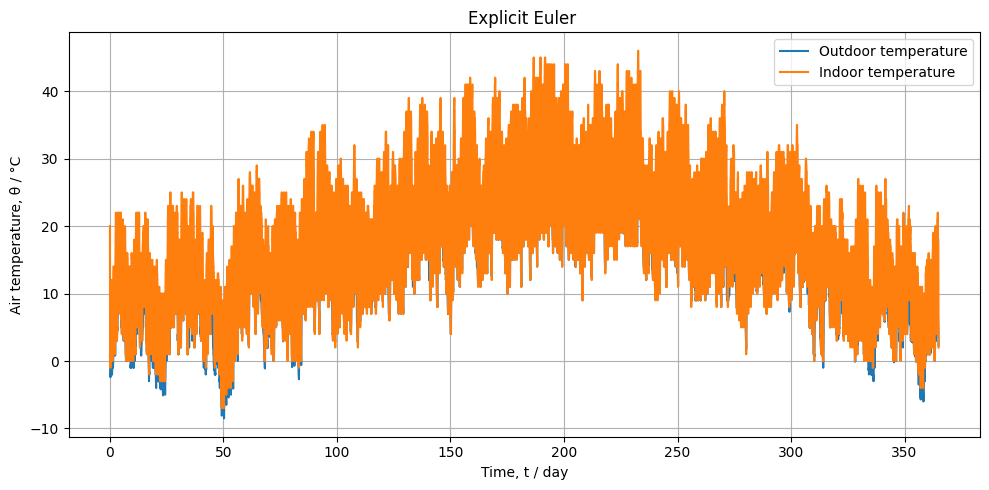

In [32]:

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
#import sys
#sys.path.append('/content/drive/My Drive')

import dm4bem  # Now you can use dm4bem.some_function(), etc.
from pathlib import Path
#State matrix
no_θ = 21
no_q = 28

#Concrete
lambda_concrete = 1.4 #W/mK # lambda = thermal conductivity
density_concrete = 2300 #kg/m^3
spec_heat_cap_concrete = 880 #J/kgK
width_concrete = 0.02/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Insulation
lambda_insulation = 0.04 #W/mK
density_insulation = 16 #kg/m^3
spec_heat_cap_insulation = 1210 #J/kgK
width_insulation = 0.08/2 #m it's divided by 2 since we only use it for the conductances, and there are 2 conductances per wall

#Window
uvalue_window = 1.4 #W/m2K
density_window = 2500 #kg/m^3
spec_heat_cap_window = 1210#J/kgK
width_window = 0.04 #m
surface_window = 1

#Door
uvalue_door = 0.9 #W/m2K
density_door = 314 #kg/m^3
spec_heat_cap_door = 2380 #J/kgK
width_door = 0.044 #m
surface_door = 2

#Walls
h_out = 10 #W/m^2*K convection coefficient between outdoor air and wall
h_in = 4 #W/m^2*K convection coefficient between indoor air and wall
l = 3 #length of walls 1,4,7
L = 4 #length of walls 2,3,5,6
surface_wall1 = surface_wall7 = L*3 #surface of walls 1,4,7
surface_wall2 = surface_wall3 = l*3 #surface of walls 2,3,5,6

#Air
density_air= 1.2
spec_heat_cap_air=1000
volume_air= 3*l*L

#P-controller gain: if Kp = 0, the controller is off
Kp1 =10**5
Kp2= 10**5

#Setpoint temeratures for the Room 1 and Room 2
Tsp1 = 25
Tsp2 = 25
Tout = -5
E = 0            #solar irradiance for summer, for winter it's 0
occupation = 0     #number of people inside
heatppl = 0.1 * occupation
alfa = 0.95        #absorptance for grey painted wall
thermal_transmittance = 0.2
total_surface = (surface_wall1*2 + surface_wall2*2)
cteforf = alfa*thermal_transmittance*E/total_surface

#Matrix A
A = np.zeros([28,21])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 6],A[6, 7] = 1, -1
A[7, 7],A[7, 8] = 1, -1
A[8, 8], A[8, 9] = 1, -1
A[9, 9], A[9, 10] = 1, -1
A[10, 10], A[10, 11] = 1, -1
A[11, 11]= 1
A[12, 6]= 1
A[13, 5] = 1
A[14, 5], A[14, 12] = 1, -1
A[15, 12], A[15, 13] = 1, -1
A[16, 13], A[16, 14] = 1, -1
A[17, 14], A[17, 15] = 1, -1
A[18, 5], A[18, 15] = 1, -1
A[19, 15] = 1
A[20, 15], A[20, 16] = 1, -1
A[21, 16], A[21, 17] = 1, -1
A[22, 17], A[22, 18] = 1, -1
A[23, 18], A[23, 19] = 1, -1
A[24, 19], A[24, 20] = 1, -1
A[25, 20]= 1
A[26, 5]= 1 #Controller 1
A[27, 15]= 1 #Controller 2

#Matrix G
g =[h_out*surface_wall2, #convection out of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_insulation*surface_wall2/width_insulation, #conduction insulation of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     lambda_concrete*surface_wall2/width_concrete, #conduction concrete of wall 2
     h_in*surface_wall2, #convection in of wall 2
     h_in*surface_wall1, #convection in of wall 1
     lambda_concrete*surface_wall1/width_concrete,#conduction concrete of wall 1
     lambda_concrete*surface_wall1/width_concrete, #conduction concrete of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     lambda_insulation*surface_wall1/width_insulation, #conduction insulation of wall 1
     h_out*surface_wall1, #convection out of wall 1
     uvalue_door, #conductance door1 of wall 1
     uvalue_window, #conductance window1 of wall 2
     h_in*surface_wall7, #convection in of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     lambda_concrete*surface_wall7/width_concrete, #conduction concrete of wall 7
     h_in*surface_wall7, #convection in of wall 7
     uvalue_door, #conductance door2 of of wall 7
     uvalue_window, #conductance window2 of wall 3
     h_in*surface_wall3, #convection in of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_concrete*surface_wall3/width_concrete, #conduction concrete of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     lambda_insulation*surface_wall3/width_insulation, #conduction insulation of wall 3
     h_out*surface_wall3,#convection out of wall 3
     Kp1, #controller Room 1 with walls 1,2,6,7
     Kp2] #controller Room 2 with walls 3,4,5,7
G = np.diag(g)

#Thermal Capacities
C_concrete1 = C_concrete7 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall1)
C_insulation1 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall1)
C_concrete2 = C_concrete3 = density_concrete*spec_heat_cap_concrete*(width_concrete*surface_wall2)
C_insulation2 = C_insulation3 = density_insulation*spec_heat_cap_insulation*(width_insulation*surface_wall2)
C_air=density_air*spec_heat_cap_air*volume_air #thermal capacity

# Matrix C
C=np.zeros([21,21])
C[1,1]=C_insulation2     #Wall 2
C[3,3]=C_concrete2       #Wall 2
C[5,5]=C_air             #Air
C[8,8]=C_concrete1       #Wall 1
C[10,10]=C_insulation1   #Wall 1
C[13,13]=C_concrete7     #Wall 7
C[15,15]=C_air           #Air
C[17,17]=C_concrete3     #Wall 3
C[19,19]=C_insulation3   #Wall 3

#b: temperature sources, associated to heat flow rate (q)
b = np.zeros(28)
b[[0,11,12,13,19,25]] = Tout #Outside temperature
b[26],b[27]= Tsp1, Tsp2 #Controller setpoints

#f: flow-rate sources, associated to the nodes (theta)
f = np.zeros(21)
f[0] = E*alfa*surface_wall2    #Wall 2
f[4] = surface_wall2*cteforf   #Wall 2
f[7] = surface_wall1*cteforf   #Wall 1
f[11] = E*alfa*surface_wall1   #Wall 1
f[12] = surface_wall7*cteforf  #Wall 7
f[14] = surface_wall7*cteforf  #Wall 7
f[16] = surface_wall3*cteforf  #Wall 3
f[20] = E*alfa*surface_wall3   #Wall 3

#y: output vector
y = np.zeros(21)  # nodes
y[[5,15]]  = 1    # nodes (temperatures) of interest

#Step-response
idx_C = np.where(np.diag(C) != 0)[0] #Indices nodes with capacities
idx_0 = np.where(np.diag(C) == 0)[0] #Indices nodes without capacities
Cc = C[np.ix_(idx_C, idx_C)] #Eliminate nodes without capacities
K = - np.transpose(A) @ G @ A
K11 = K[np.ix_(idx_0, idx_0)]
K12 = K[np.ix_(idx_0, idx_C)]
K21 = K[np.ix_(idx_C, idx_0)]
K22 = K[np.ix_(idx_C, idx_C)]
Kb = np.transpose(A) @ G
Kb1 = Kb[idx_0, :] #Extract the rows of Kb of nodes whitout capacities
Kb2 = Kb[idx_C, :] #Extract the rows of Kb of nodes with capacities
fc = f[idx_C] #flow sources at nodes with capacities
f0 = f[idx_0] #flow sources at nodes without capacities
u = np.concatenate([b, f0, fc])

#As state matrix
As = np.linalg.inv(Cc) @ (-K21 @ np.linalg.inv(K11) @ K12 + K22)
#Bs input matrix
Bs = np.linalg.inv(Cc) @ np.hstack([-K21 @ np.linalg.inv(K11) @ Kb1 + Kb2, -K21 @ np.linalg.inv(K11), np.eye(len(idx_C))])
#Cs output matrix
Cs = -np.linalg.inv(K11) @ K12
#feedthrough
#Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0))])
Ds = -np.linalg.inv(K11) @ np.hstack([Kb1, np.eye(len(idx_0)), np.zeros((len(idx_0), len(idx_C)))])

#Solve the state-space equation
#Inputs
t_start = 0
t_end = 100
t_eval = np.linspace(t_start, t_end, 100) #Evaluate at time points
θc_initial = np.zeros(len(idx_C))
#Define the system
def state_space_system(t, θc, As, Bs, u):
    d_θc_dt = As @ θc + Bs @ u
    return d_θc_dt
#Solve the state equation
sol = solve_ivp(state_space_system, (t_start, t_end), θc_initial, args=(As, Bs, u), t_eval=t_eval, dense_output=True)
#Extract θc, θ0, q
theta_C_t = sol.y.T #Extract solution for θc
theta_0_t = Cs @ sol.y + Ds @ u.reshape(-1, 1) #Extract the soluction for θ0
theta_t = np.vstack([theta_0_t, theta_C_t.T]) #Complete temperature vector
q_t = G @ (-A @ theta_t + b.reshape(-1, 1)) #Heat transfer flows q

# --- Weather Data ---
start_date = '2000-04-10'
end_date = '2000-05-15'
filename = Path('FRA_Lyon.074810_IWEC.epw')
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[['temp_air']]
tw = np.arange(weather.shape[0]) * 3600

# Model parameters
rho = 1.3
V = 125
cp = 1005
UA = 150
Q_heater = 2000

Δt = 600  # 10 minutes
t = np.arange(0, weather.shape[0] * 3600, Δt)
To = np.interp(t, tw, weather['temp_air'])
Qh = np.zeros_like(t)
hours = (t / 3600) % 24
Qh[(hours >= 6) & (hours <= 22)] = Q_heater
Ti = np.zeros_like(t)
Ti[0] = 20

for k in range(len(t) - 1):
    dTdt = (Qh[k] + UA * (To[k] - Ti[k])) / (rho * V * cp)
    Ti[k + 1] = Ti[k] + Δt * dTdt
    if np.isnan(Ti[k + 1]) or np.isinf(Ti[k + 1]):
        print(f"Numerical error at step {k+1}, Ti={Ti[k+1]}")
        break

plt.figure(figsize=(10,5))
plt.plot(t / 3600 / 24, To, label='Outdoor temperature')
plt.plot(t / 3600 / 24, Ti, label='Indoor temperature')
plt.xlabel('Time, t / day')
plt.ylabel('Air temperature, θ / °C')
plt.title('Explicit Euler ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()